# Text data with pytorch

##### 2.1 Word embedding:
## 2.1.1. Reading `txt` files, tokenizing texts and building a vocabulary
## 2.1.2. Define Vocabulary
## 2.1.3. Continous bag of words using embedding layer
- 2.1.4. Train models and evaluate performance
- 2.1.5. Compute cosine similarity matrix of the vocabulary based on the trained embedding
- 2.1.6. Visualize the embedding space

##### 2.2 Conjugating be and have:
- 2.2.1 Attention Layer
- 2.2.2. Train models and evaluate performance

##### 2.3 Text generation:
- 2.3.1. Next Word
- 2.3.2. Train models and evaluate performance
- 2.3.3. Beam Search
- 2.3.3. Sentence creation


_______________________________________________

# 2.1 Word embedding

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import numpy as np

import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import vocab as Vocab

from utils import train, set_device, compute_accuracy

import matplotlib.pyplot as plt

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

from collections import Counter, OrderedDict

device = torch.device("cpu")
print(f"Device {device}.")


Device cpu.


Define the paths of the generated files to distribute the files in the system

In [2]:
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/'
PATH_WORDS = "words/"
PATH_DATA = "data/"
PATH_MODELS = "models/"

## 2.1.1. Reading `txt` files, tokenizing texts and building a vocabulary

In [3]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')

# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

# If you want to remove some characters to get rid of noise
# specials=["<unk>", ",", ".", "!", "?"] 
specials = []

# List of posible words to use
target_words = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]
taget_words_size = len(target_words) 


def read_files(datapath='./data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]
    
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[09]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        # Remove special characters
        line = ''.join([char for char in line if char not in specials])
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """

    vocab_stoi = vocab.get_stoi()

    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        if w in vocab_stoi:
            freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    # SANITAZE THE INPUT, Get rid of the unkown words 

    return vocab

## 2.1.2. Define Vocabulary

In [4]:
# ----------------------- Tokenize texts -------------------------------
# Load tokenized versions of texts if you have already generated it
# Otherwise, create it and save it

if os.path.isfile(PATH_GENERATED + PATH_WORDS +"words_train.pt"):
    words_train = torch.load(PATH_GENERATED + PATH_WORDS +"words_train.pt")
    words_val = torch.load(PATH_GENERATED + PATH_WORDS +"words_val.pt")
    words_test = torch.load(PATH_GENERATED + PATH_WORDS +"words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('./data_train/')
    lines_books_val = read_files('./data_val/')
    lines_books_test = read_files('./data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED + PATH_WORDS +"words_train.pt")
    torch.save(words_val , PATH_GENERATED + PATH_WORDS +"words_val.pt")
    torch.save(words_test , PATH_GENERATED + PATH_WORDS +"words_test.pt")


# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = PATH_GENERATED + PATH_WORDS + "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(VOCAB_FNAME):
    vocab = torch.load(VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, VOCAB_FNAME)
    


Now lets sanitaze the data we have

------------Normal Database---------------
Total number of words in the training dataset:              2684706
Total number of words in the validation dataset:            49526
Total number of words in the test dataset:                  124152
Number of distinct words in the training dataset:           52105
Number of distinct words kept (vocabulary size):            1887
Possible words prediction:  12 ,  ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']


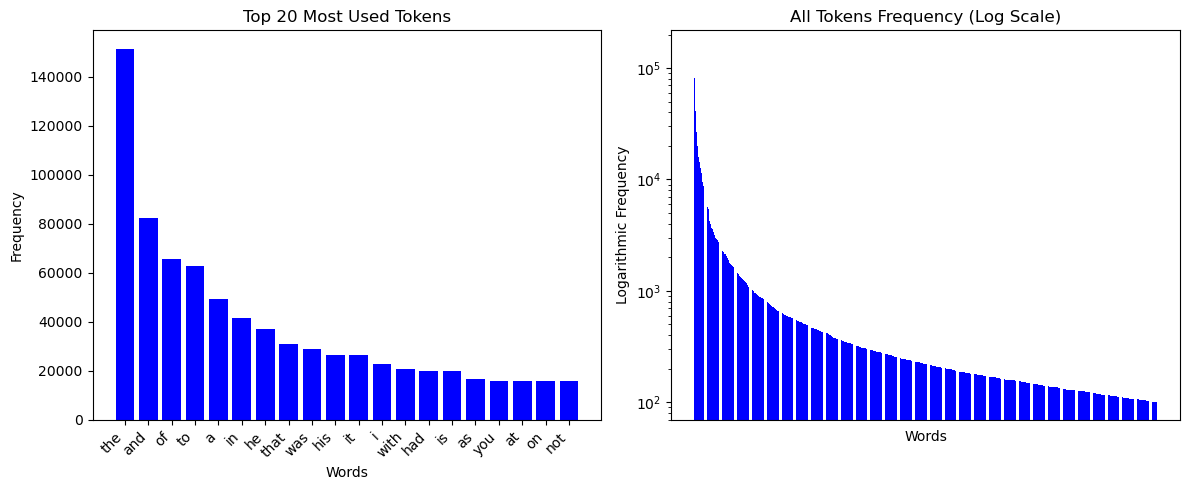

In [48]:
# ------------------------ Quick analysis  ------------------------------

VOCAB_SIZE = len(vocab)
vocab_itos = vocab.get_itos()

TARGET_OUTPUT = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]

print("------------Normal Database---------------")
print("Total number of words in the training dataset:             ", len(words_train))
print("Total number of words in the validation dataset:           ", len(words_val))
print("Total number of words in the test dataset:                 ", len(words_test))
print("Number of distinct words in the training dataset:          ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):           ", VOCAB_SIZE)

print("Possible words prediction: ", len(TARGET_OUTPUT),", ", TARGET_OUTPUT)

freqs = count_freqs(words_train, vocab)

occurrences = [(f.item(), w) for (f, w) in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))]
specials = ["<unk>", ",", ".", "!", "?"]

# Filtrar las ocurrencias para eliminar palabras especiales
filtered_occurrences = [(freq, word) for freq, word in occurrences if word not in specials]
top_occurrences = sorted(filtered_occurrences, key=lambda x: x[0], reverse=True)

top_occurrences_words = []
top_occurrences_freq = []
for freq, word in top_occurrences:
    top_occurrences_words.append(word)
    top_occurrences_freq.append(freq)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize to fit your display

# Bars Graph for Top 20 most used Tokens
axes[0].bar(top_occurrences_words[:20], top_occurrences_freq[:20], color='blue')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 20 Most Used Tokens')
axes[0].set_xticks(range(len(top_occurrences_words[:20])))
axes[0].set_xticklabels(top_occurrences_words[:20], rotation=45, ha='right')

# Bars Graph for All Words with a Logarithmic scale
axes[1].bar(top_occurrences_words, top_occurrences_freq, color='blue')
axes[1].set_yscale('log')  # Set the y-axis to a logarithmic scale
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Logarithmic Frequency')
axes[1].set_title('All Tokens Frequency (Log Scale)')
axes[1].set_xticks([])  # Optionally, remove x-tick labels for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()    

Prepare the weights value for the loss function

In [49]:
import torch

epsilon = 1e-5
freqs_adjusted = freqs + epsilon  # Adjust frequencies to avoid zero

total_samples = torch.sum(freqs_adjusted)
class_weights = total_samples / freqs_adjusted
class_weights = class_weights / torch.sum(class_weights)  # Normalize to sum to 1

print("Adjusted Frequencies:", freqs_adjusted)
print("Total Samples:", total_samples)
print("Initial Weights:", class_weights)
print("Normalized Weights:", class_weights)


Adjusted Frequencies: tensor([1.0000e-05, 1.8254e+05, 1.5128e+05,  ..., 1.8200e+02, 1.0000e+02,
        2.2996e+04])
Total Samples: tensor(2252489.0189)
Initial Weights: tensor([9.9991e-01, 5.4779e-11, 6.6098e-11,  ..., 5.4940e-08, 9.9991e-08,
        4.3482e-10])
Normalized Weights: tensor([9.9991e-01, 5.4779e-11, 6.6098e-11,  ..., 5.4940e-08, 9.9991e-08,
        4.3482e-10])


Create the dataset

In [50]:
def create_aroundTarget_dataset(text, vocab, before_context_size, after_context_size, target_words=None, target_to_idx=None):
    contexts = []
    targets = []
    lenText = len(text)

    # If specified target words are given
    if target_words is not None and target_to_idx is not None:

        for i in range(before_context_size, lenText - after_context_size):

            word = text[i]
            # Case if the target words are specified
            if word in target_words:

                t = target_to_idx[word]
                
                around = (
                    text[i - before_context_size : i]
                    + text[i + 1 : i + after_context_size + 1]
                )

                c = torch.Tensor([vocab[w] for w in around]).type(torch.long)

                # The index of the target has to be from 0 to 11 not the vocab one
                targets.append(t)
                contexts.append(c)

    # No target words were specified
    elif target_words is None and target_to_idx is None:
        txt = [vocab[w] for w in text]

        for i in range(before_context_size, lenText - after_context_size):

            t = txt[i]

            around = (
                    text[i - before_context_size : i]
                    + text[i + 1 : i + after_context_size + 1]
            )

            c = torch.Tensor([vocab[w] for w in around]).type(torch.long)


            targets.append(t)
            contexts.append(c)

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname, before_context_size, after_context_size, target_words=None, target_to_idx=None):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + PATH_DATA + fname):
        dataset = torch.load(PATH_GENERATED+ PATH_DATA + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_aroundTarget_dataset(words, vocab, before_context_size, after_context_size, target_words=target_words, target_to_idx=target_to_idx)
        torch.save(dataset, PATH_GENERATED + PATH_DATA + fname)
    return dataset


Create the dataset

In [51]:
before_context_size= 5
after_context_size= 5
batch_size = 64

# Normal Data Train
data_train = load_dataset(words_train, vocab, "data_train.pt", before_context_size, after_context_size)
data_val = load_dataset(words_val, vocab, "data_val.pt", before_context_size, after_context_size)
data_test = load_dataset(words_test, vocab, "data_test.pt", before_context_size, after_context_size)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

Check that the train data is well created

In [52]:
index = (20,23)

print(" NORMAL DATASBASE")
for i in range(*index):
    input_tensor, target_tensor = data_train[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Para el tensor objetivo
    phrase = ""

    for i,value in enumerate(input_tensor):
        phrase += vocab_itos[value]+ " "
    
    phrase += vocab_itos[target_tensor]
    print("Input: ", input_tensor, "-> ", phrase, " Target: ", target_tensor)


        

 NORMAL DATASBASE
Input:  [5, 0, 10, 11, 48, 51, 5, 75, 0, 225] ->  of <unk> he was an man of about <unk> years old  Target:  93
Input:  [0, 10, 11, 48, 93, 5, 75, 0, 225, 5] ->  <unk> he was an old of about <unk> years of man  Target:  51
Input:  [10, 11, 48, 93, 51, 75, 0, 225, 5, 647] ->  he was an old man about <unk> years of age of  Target:  5


As we can see sometimes getting rid of the unkwown characters could lead into a better understanding of the context

## 2.1.3. Continous bag of words using embedding layer

Model 1

In [53]:
class NGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, before_context_size, after_context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * (before_context_size + after_context_size), hidden_dim) # Before and after
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1))
        out = self.linear1(embeds)
        out = F.relu(out) # Adding ReLU activation function for non-linearity
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

Model Simple. No activation function, linear tranformations

In [54]:
class NGramSimple(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, before_context_size, after_context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * (before_context_size + after_context_size), hidden_dim) # Before and after
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1))
        out = self.linear1(embeds)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

## 2.1.4. Train models and evaluate performance



In [55]:

def train(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    device = set_device(device)

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    loss_train = 0.0
    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        current_loss = loss_train / n_batch
        losses_train.append(current_loss)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, current_loss))
        # Check if the average of the last 5 losses is less than 0.001
        if len(losses_train) >= 5:
            # Calculate the average of the last 5 recorded losses
            avg_loss = abs(sum(losses_train[-5:]) / 5)
            print(" -Average loss for the last 5 epochs was:", avg_loss)
            if avg_loss < 0.001:
                print('Average loss of the last 5 epochs is less than 0.001, stopping training.')
                break
    return losses_train

def relative_error(a, b):
    return torch.norm(a - b) / torch.norm(a)

Modelos

In [56]:
titles = []
models = []

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights) 
# use weights based on each class frequency 
# to alleviate the effects of class imbalance when training 


We train a Simple model first

In [59]:
Ngram_counter = 1

NGRAM_PATH = PATH_GENERATED + PATH_MODELS + f"NGram_Simple_{Ngram_counter}.pt"
if os.path.isfile(NGRAM_PATH):
    NGram_model = torch.load(NGRAM_PATH)
else:
    n_epochs = 30
    lr = 0.005
    embedding_dim = 16
    hidden_dim = 128

    NGram_model = NGram(len(vocab), embedding_dim, hidden_dim, before_context_size, after_context_size).to(device=device)
    optimizer = optim.SGD(NGram_model.parameters(), lr=lr)

    weight = train(
        n_epochs=n_epochs,
        optimizer=optimizer,
        model=NGram_model,
        loss_fn=loss_fn,
        train_loader=train_loader,
    )
    
    torch.save(NGram_model, NGRAM_PATH)

titles.append(f"NGram_Simple_{Ngram_counter}")
models.append(NGram_model)

On device cpu.


02:30:53.504962  |  Epoch 1  |  Training loss 4.73976


We will train 4 different models, changing the embedding dimesions and the hidden layer dimensions from 128 to 512.

In [ ]:

embedding_dims = [128, 512]
hidden_dims = [128, 512]

for embedding_dim in embedding_dims:
    for hidden_dim in hidden_dims:
        Ngram_counter += 1
        NGRAM_PATH = PATH_GENERATED + PATH_MODELS + f"NGram_{Ngram_counter}.pt"
        if os.path.isfile(NGRAM_PATH):
            NGram_model = torch.load(NGRAM_PATH)
        else:
            n_epochs = 30
            lr = 0.005

            NGram_model = NGram(len(vocab), embedding_dim, hidden_dim, before_context_size, after_context_size).to(device=device)
            optimizer = optim.SGD(NGram_model.parameters(), lr=lr)

            weight = train(
                n_epochs=n_epochs,
                optimizer=optimizer,
                model=NGram_model,
                loss_fn=loss_fn,
                train_loader=train_loader,
            )
            
            torch.save(NGram_model, NGRAM_PATH)

        titles.append(f"NGram_{Ngram_counter}")
        models.append(NGram_model)

On device cpu.
13:17:20.384810  |  Epoch 1  |  Training loss 4.70978
13:24:05.518661  |  Epoch 5  |  Training loss 3.98645
13:32:41.889255  |  Epoch 10  |  Training loss 3.78303
13:41:10.039126  |  Epoch 15  |  Training loss 3.67866
13:49:26.081779  |  Epoch 20  |  Training loss 3.60911
13:57:43.354227  |  Epoch 25  |  Training loss 3.55759
14:05:57.699502  |  Epoch 30  |  Training loss 3.51695
14:14:14.298001  |  Epoch 35  |  Training loss 3.48373
14:22:31.357601  |  Epoch 40  |  Training loss 3.45598
14:30:52.135596  |  Epoch 45  |  Training loss 3.43233
14:39:07.706779  |  Epoch 50  |  Training loss 3.41179
14:47:24.686582  |  Epoch 55  |  Training loss 3.39367
14:56:16.729026  |  Epoch 60  |  Training loss 3.37751
15:04:38.117363  |  Epoch 65  |  Training loss 3.36294
15:13:43.881418  |  Epoch 70  |  Training loss 3.34969
15:22:38.867362  |  Epoch 75  |  Training loss 3.33753
15:30:45.286428  |  Epoch 80  |  Training loss 3.32632
15:38:25.156463  |  Epoch 85  |  Training loss 3.315

Now show a real example of the prediction

In [ ]:

def showPredict_single_example(model, input, vocab):
    first_input, first_label = input

    first_input = first_input.unsqueeze(0)  # Agrega una dimensión de batch
    first_label = torch.tensor([first_label])  # Asegúrate de que está en formato tensor    
    # Asumiendo que rnn_model es tu modelo y ya está cargado y movido al dispositivo adecuado
    model.eval()  # Coloca el modelo en modo de evaluación

    # Realiza la predicción
    with torch.no_grad():
        output = model(first_input)
        _, predicted_index = torch.max(output, 1)
        predicted_index = predicted_index.item()  # Convierte el tensor a un entero Python

    input_tensor, target_tensor = input
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = ""

    # Añadir las primeras 5 palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += vocab[value] + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += "*"+ vocab[target_tensor] + "* "

    # Añadir los últimos 2 valores del input_tensor a la frase
    for value in input_tensor[-after_context_size:]:
        phrase += vocab[value] + " "

    # Imprimir la frase completa
    predicted_word = vocab[predicted_index]
    real_word = vocab[first_label.item()]
    print(f"[Predicted Word: {predicted_word},\tReal Word: {real_word}]", " \t-> Phrase: ", phrase.strip())


def showPredictSamples(models, modelTitles, vocab, loader, since=None, to=None):

    for i, model in enumerate(models):
        model_title= modelTitles[i]
        print("\n***************** Prediccting model: ", model_title, "*****************")
        if since is not None and to is not None:
            for i in range (since,to):
                showPredict_single_example(model, loader[i], vocab)
        else:
            for sample in loader:
                showPredict_single_example(model, loader[i], vocab)

# train_loaders=[(train_conjugate_data_loader_5_5,"Before=5,After=5") , (train_conjugate_data_loader_12_6, "Before=12,After=6")]
showPredictSamples(models, titles, vocab, data_train, since=110, to=113)


Test accuracy

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of model with given data loader
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / len(loader.dataset)

def model_selection(models, titles, train_loader, val_loader):
    """
    Choose the best model from the list of models based on validation accuracy
    """
    best_model = None
    best_acc = 0
    for model, title in zip(models, titles):
        acc = accuracy(model, val_loader)
        train_acc = accuracy(model, train_loader)
        print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
        if acc > best_acc:
            best_model = model
            best_acc = acc
    return best_model

best_model = model_selection(
    models, titles, train_loader, val_loader
)

print(best_model)

best_model_acc = accuracy(best_model, test_loader)
print(f"Best conjugating model | Test accuracy {best_model_acc:.2%}")



NGram | Train accuracy 30.46% |  Validation accuracy 29.92%
NGram(
  (embeddings): Embedding(1887, 16)
  (linear1): Linear(in_features=160, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1887, bias=True)
)
Best conjugating model | Test accuracy 33.87%


Show the model results

## 2.1.5. Compute cosine similarity matrix of the vocabulary based on the trained embedding

In [ ]:
SIM_MATRIX_PATH = "SimilarityMatrix.pt"
best_model_weights = best_model.embeddings.weight.detach()

if os.path.isfile(PATH_GENERATED + SIM_MATRIX_PATH):
    sim_matrix = torch.load(PATH_GENERATED + SIM_MATRIX_PATH)
else:
    sim_matrix = np.zeros(shape=(len(best_model_weights), len(best_model_weights)))

    for w1 in range(0, len(best_model_weights)):
        for w2 in range(0, len(best_model_weights)):
            # Cosine similarity
            sim_matrix[w1][w2] = np.dot(best_model_weights[w1], best_model_weights[w2]) / (
                np.linalg.norm(best_model_weights[w1]) * np.linalg.norm(best_model_weights[w2])
            )
    
    torch.save(sim_matrix , PATH_GENERATED + SIM_MATRIX_PATH)


3 3


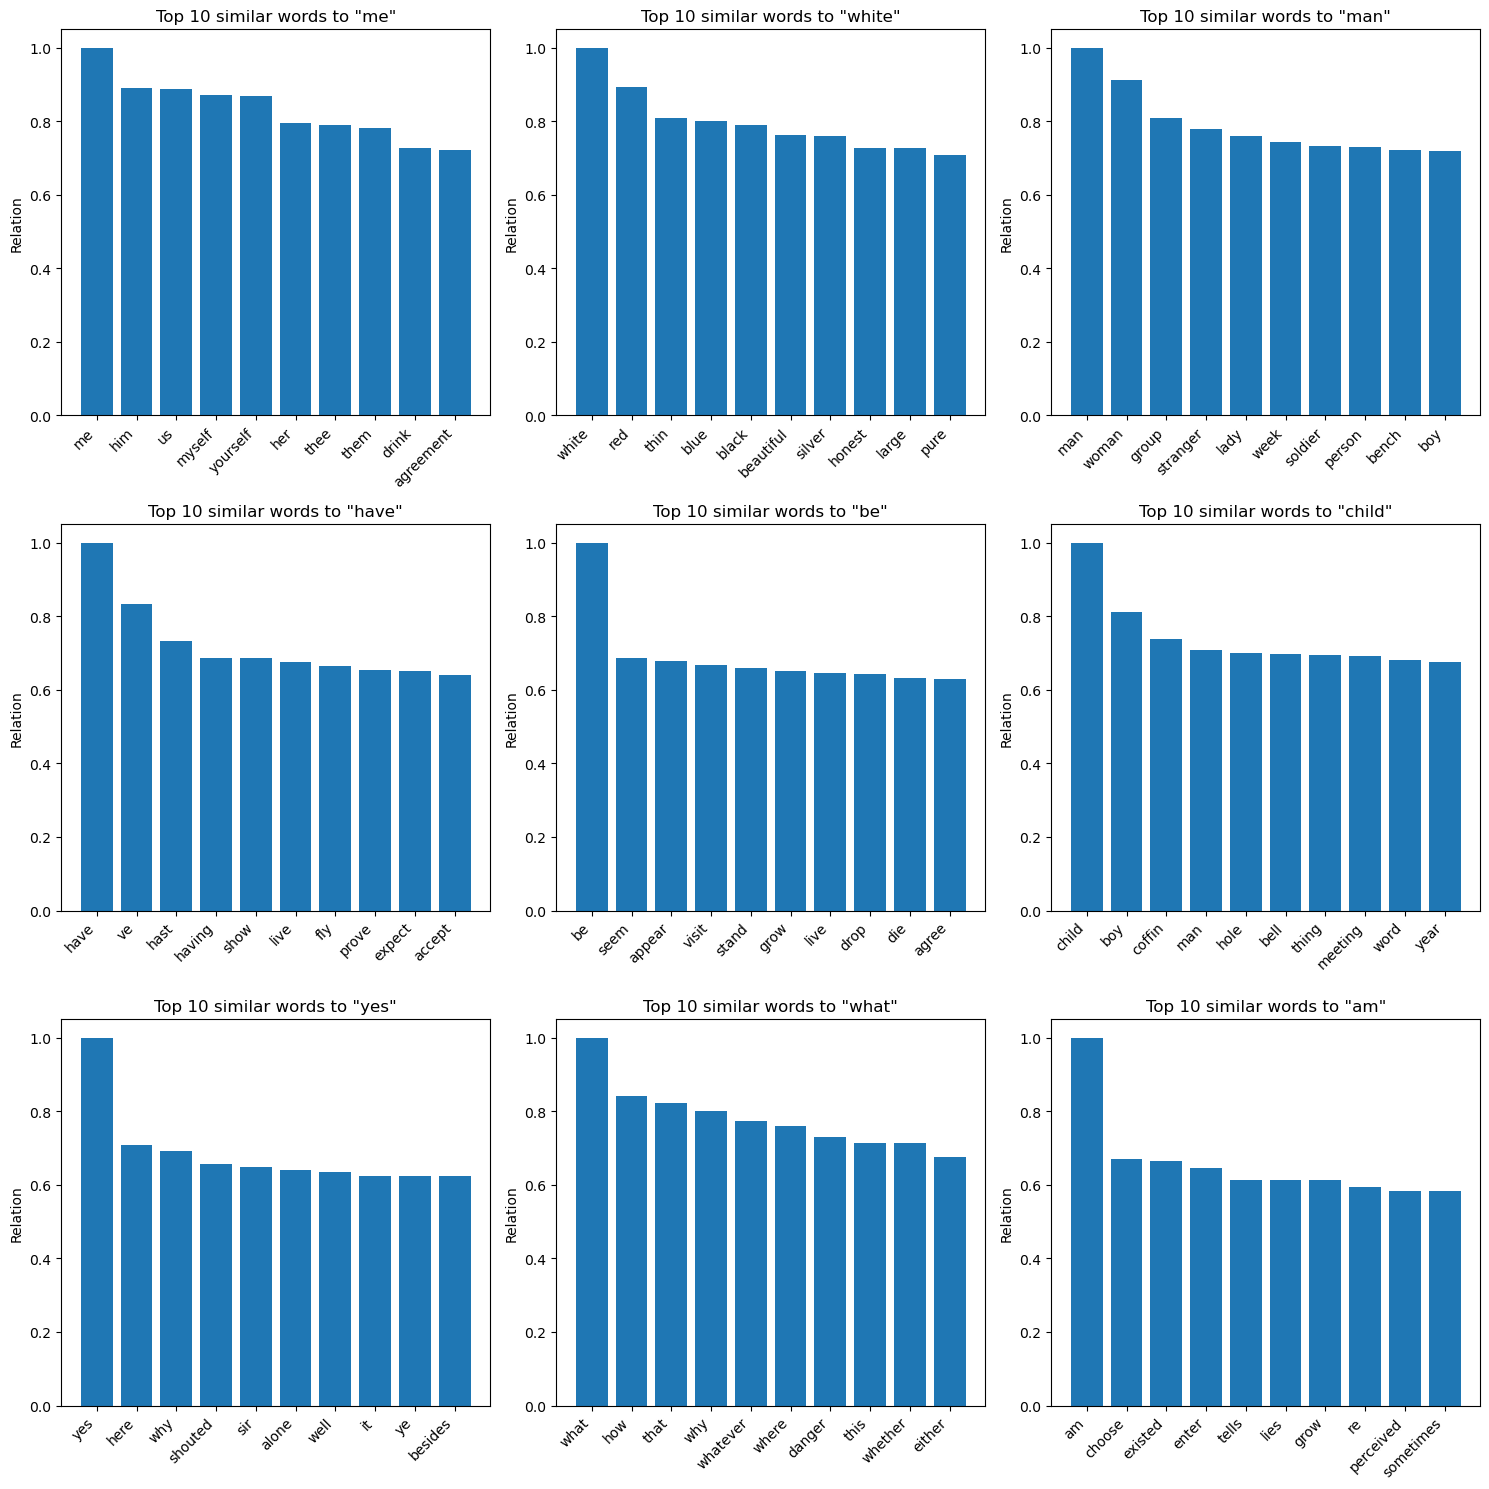

In [ ]:
testing_words = ["me", "white", "man", "have", "be", "child", "yes", "what", 'am']
vocab_stoi = vocab.get_stoi()
testing_words_idx = [(i, vocab.get_stoi()[i]) for i in testing_words]


sim_words_dict =  []
n_most_similar = 10
for i,w in enumerate(testing_words_idx):

    indices = (-sim_matrix[w[1]]).argsort()[:n_most_similar]
    sim_words = [(vocab_itos[i], sim_matrix[w[1]][i]) for i in indices]

    x_words = []
    y_relate = []

    for word, relate in sim_words:
        x_words.append(word)
        y_relate.append(relate)

    sim_words_dict.append((w[0], x_words, y_relate))

n_plots = len(testing_words)
n_cols = 3
n_rows = (len(testing_words) + n_cols - 1) // n_cols  # Calculate needed rows, round up
print(n_rows, n_cols)
# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows)) 
  
# Plotting each set of similar words
i=0
for row in range(n_rows):
    for col in range(n_cols):
        if i < n_plots:
            word, related_words, related_ratio = sim_words_dict[row*n_cols + col]
            axis[row,col].bar(related_words, related_ratio)
            axis[row,col].set_title(f'Top {n_most_similar} similar words to "{word}"') 
            axis[row,col].set_xticks(range(len(related_words)))
            axis[row,col].set_xticklabels(related_words, rotation=45, ha='right')
            axis[row,col].set_ylabel('Relation')
            i += 1
        
plt.tight_layout()
plt.show()

## 2.1.6. Visualize the embedding space

In [ ]:
import csv

with open(PATH_GENERATED +"./weights.tsv", "wt") as out_file:
    tsv_writer = csv.writer(out_file, delimiter="\t")
    for i in best_model_weights:
        tsv_writer.writerow(i.numpy())


with open(PATH_GENERATED +"./metadata.tsv", "wt") as out_file:
    tsv_writer = csv.writer(out_file, delimiter="\t")
    for i in vocab_itos:
        tsv_writer.writerow([i])



![Captura desde 2024-04-23 01-39-41.png](<attachment:Captura desde 2024-04-23 01-39-41.png>)

![Captura desde 2024-04-23 01-38-52.png](<attachment:Captura desde 2024-04-23 01-38-52.png>)
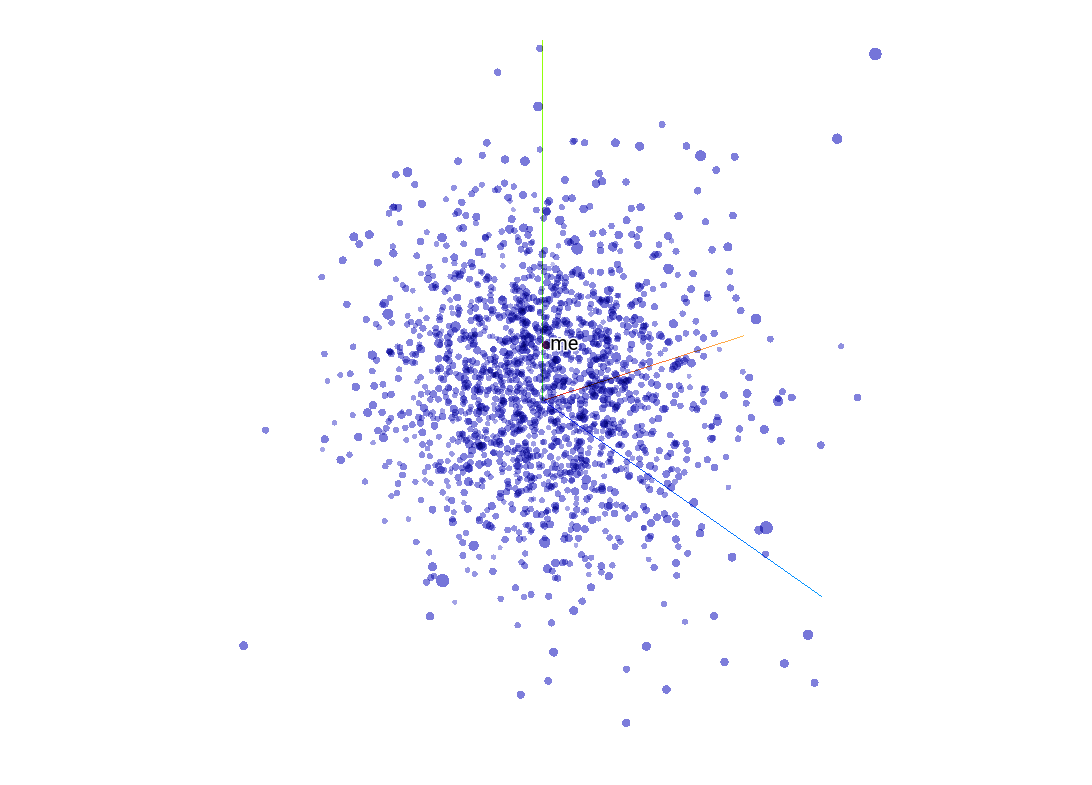
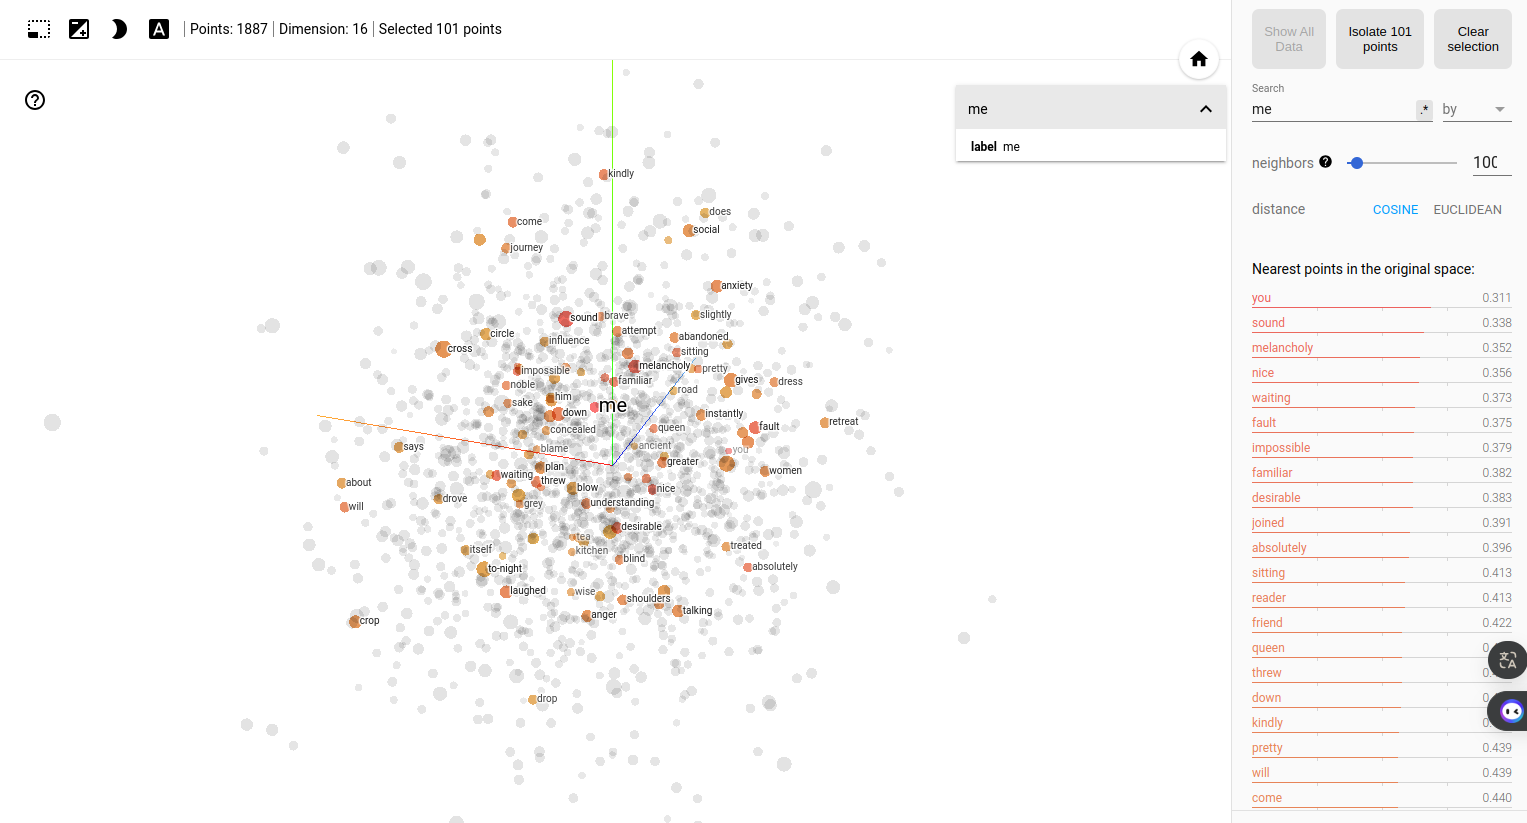
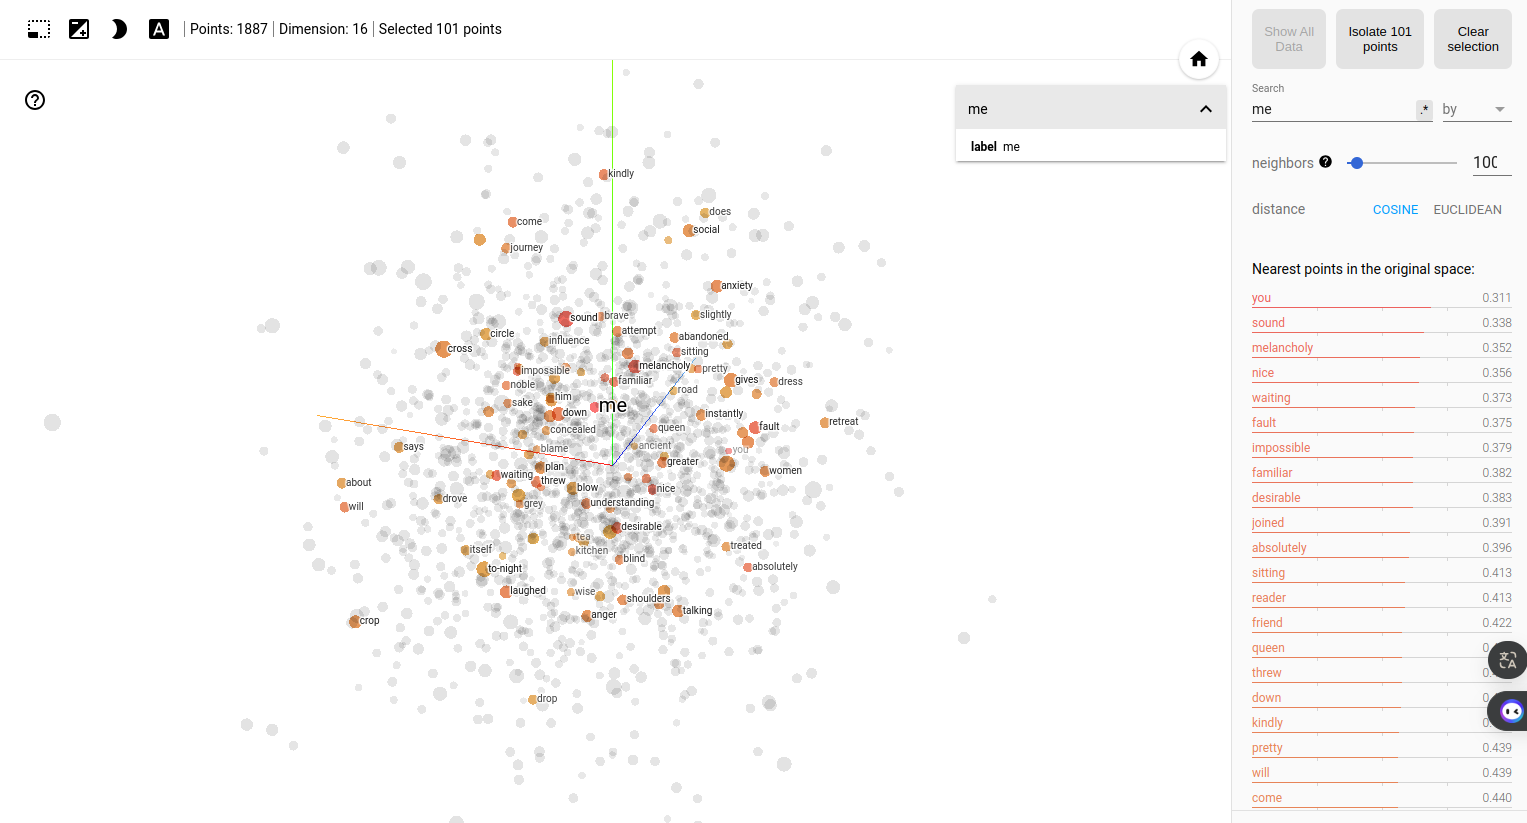

_______________________________
# 2.2 Conjugating be and have:

For this part we would first need to make the 12 first words in our vocab be the possible conjugations as the neuronal netowrk will give a value from 0-11. This will ensure that the output word is one the conjugations

In [ ]:
counter = Counter(words_train)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)

target_output = []

for element in sorted_by_freq_tuples:
    # Put the chosen ones at the beggining
    if element[0] in TARGET_OUTPUT:
        target_output.insert(0, element)
    else:
        target_output.append(element)

ordered_dict = OrderedDict(target_output)
specials = TARGET_OUTPUT + ['<unk>']
vocab_conjugate = Vocab(ordered_dict, specials=specials)
vocab_conjugate.set_default_index(vocab_conjugate['<unk>'])
vocab_conjugate_dict = vocab_conjugate.get_itos()


Show the frequency of the target words

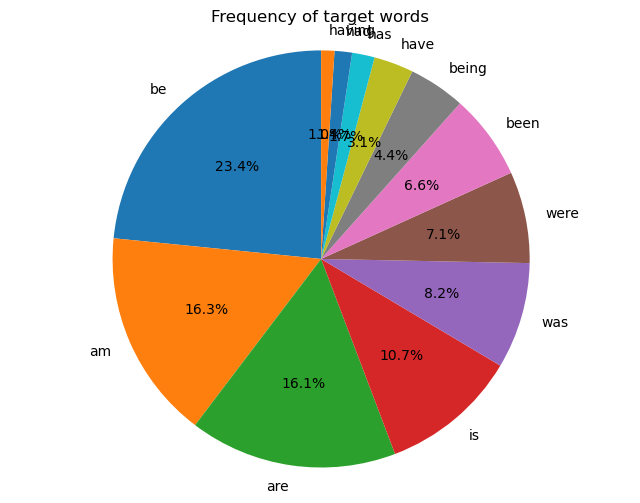

In [ ]:

occurrences_targetWords_freq = [freq for freq, word in occurrences if word in TARGET_OUTPUT]

# Etiquetas para el gráfico, que son nuestras palabras objetivo

# Verificar que el tamaño total no es cero para evitar errores de división por cero en gráficos vacíos
if sum(occurrences_targetWords_freq) > 0:
    plt.figure(figsize=(8, 6))
    plt.pie(occurrences_targetWords_freq, labels=TARGET_OUTPUT, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Esto asegura que el gráfico de pastel sea un círculo
    plt.title('Frequency of target words')
    plt.show()
else:
    print("Target words are not in the text")

For each word we can predict show the most common preciding word

Studyng the word be most common preceding and following words


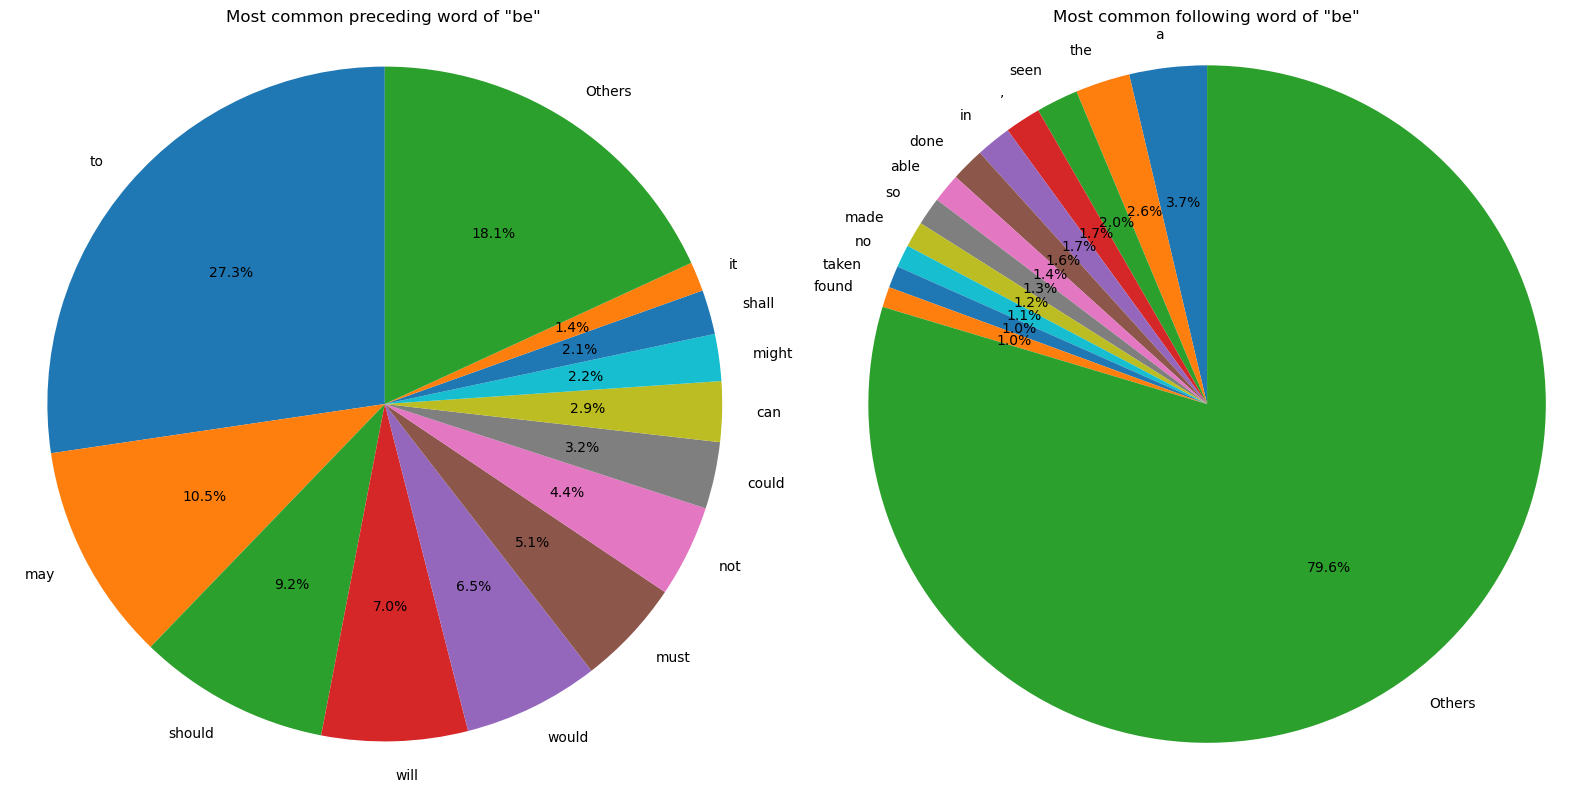

Studyng the word am most common preceding and following words


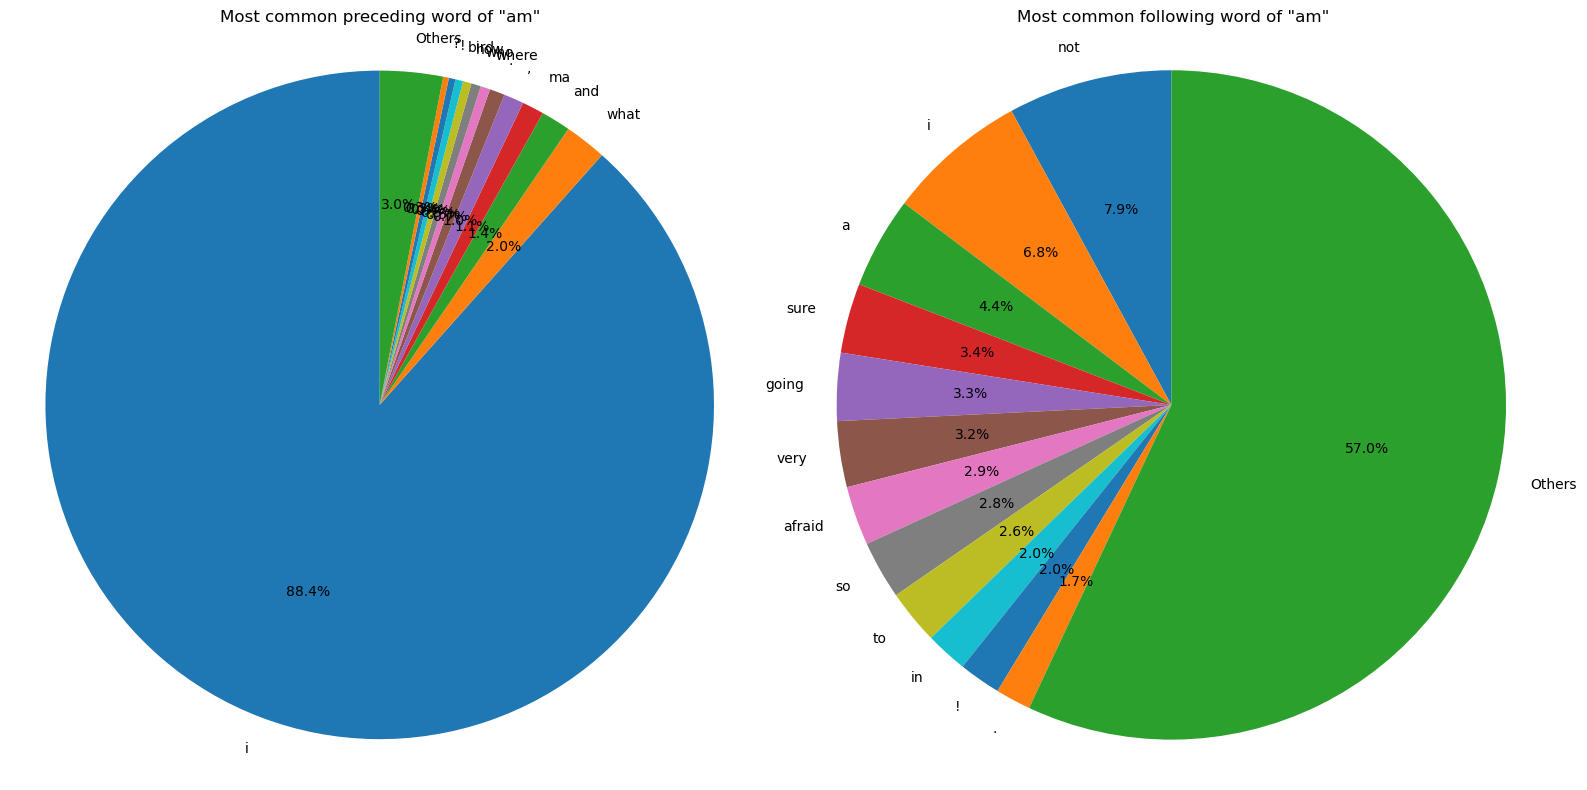

Studyng the word are most common preceding and following words


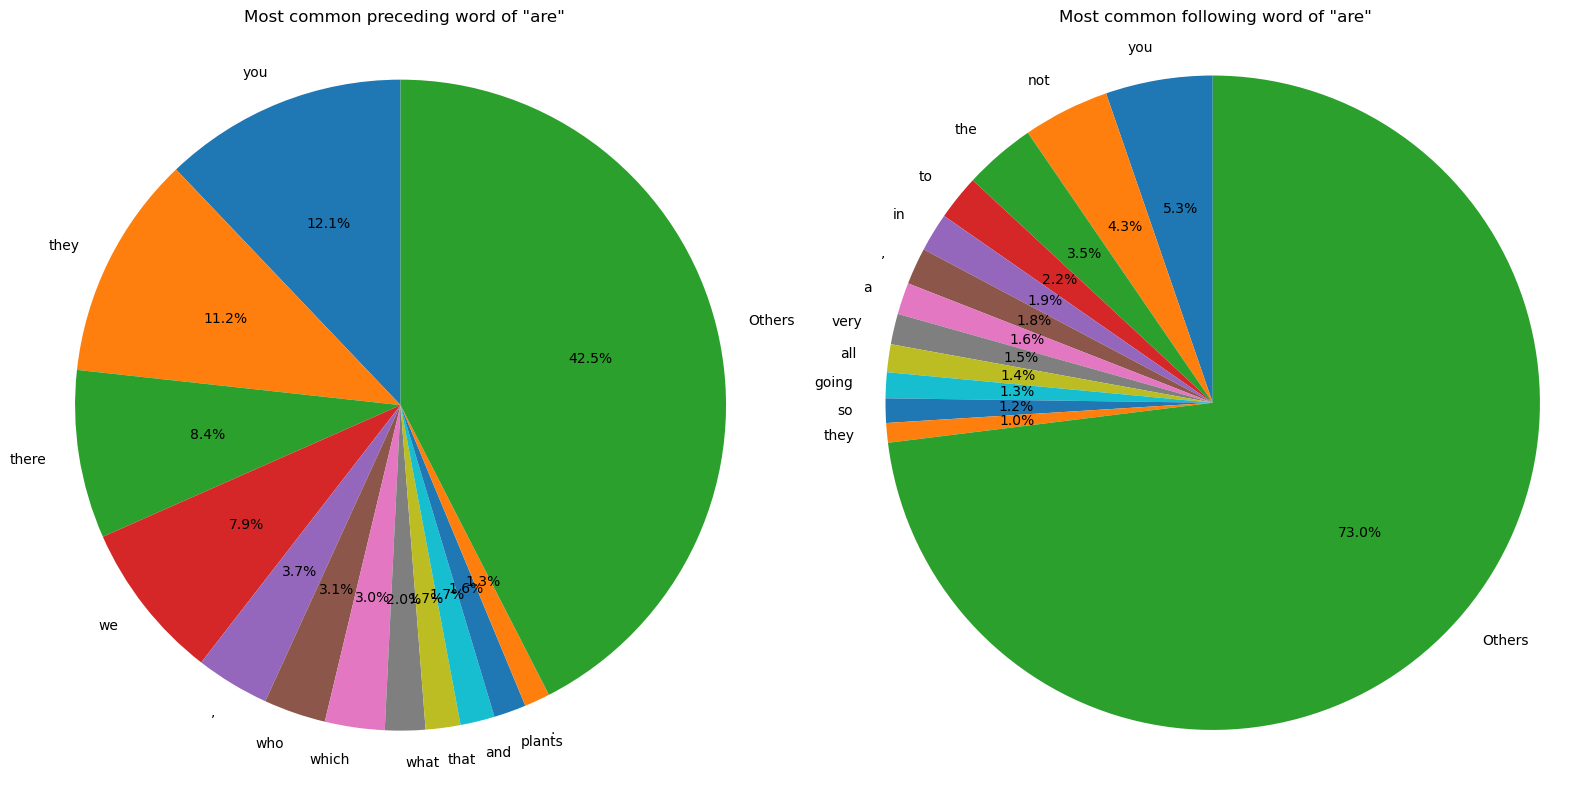

Studyng the word is most common preceding and following words


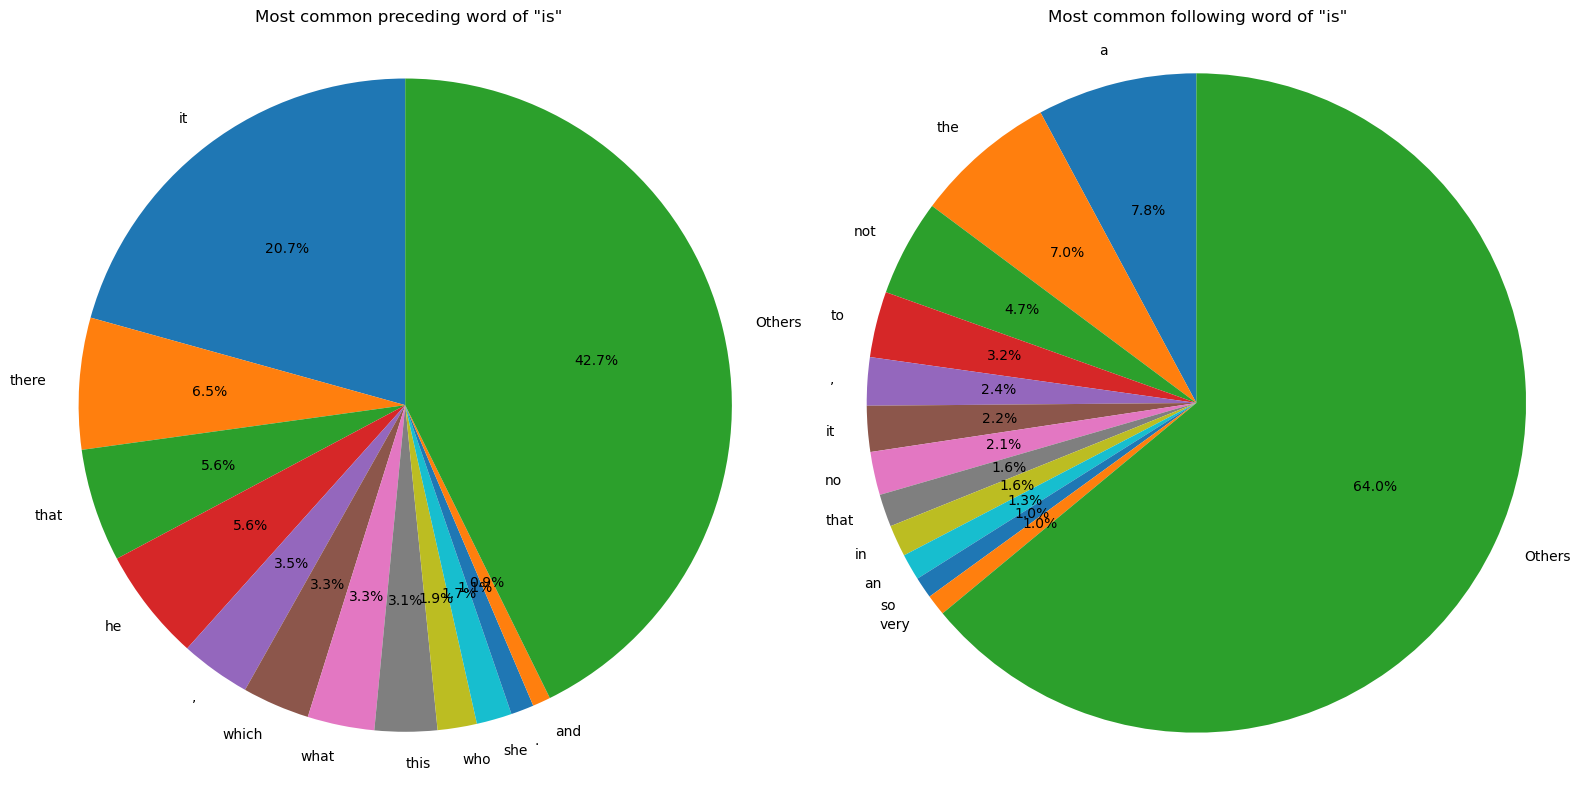

Studyng the word was most common preceding and following words


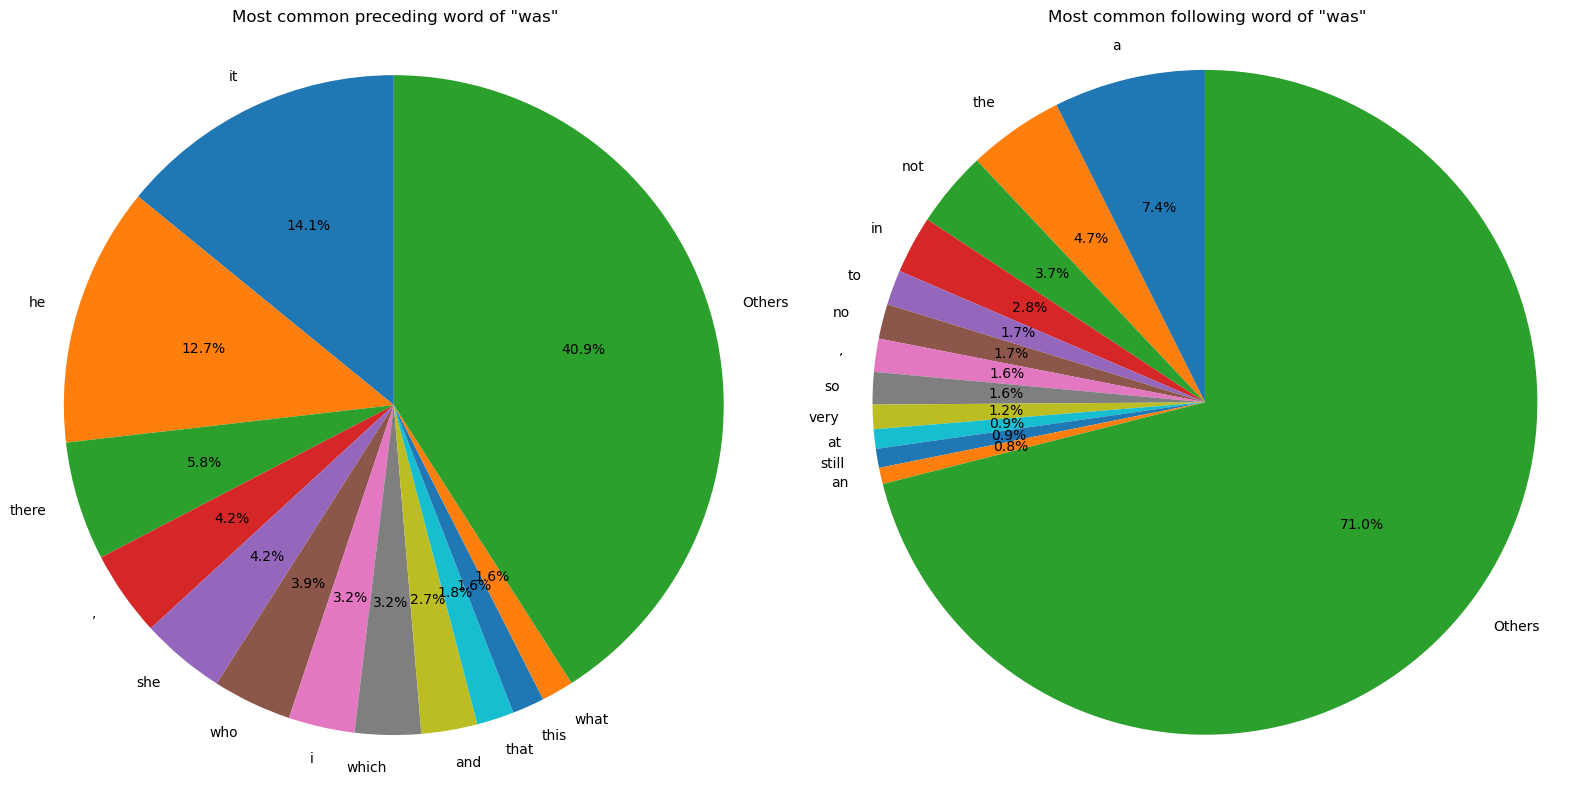

Studyng the word were most common preceding and following words


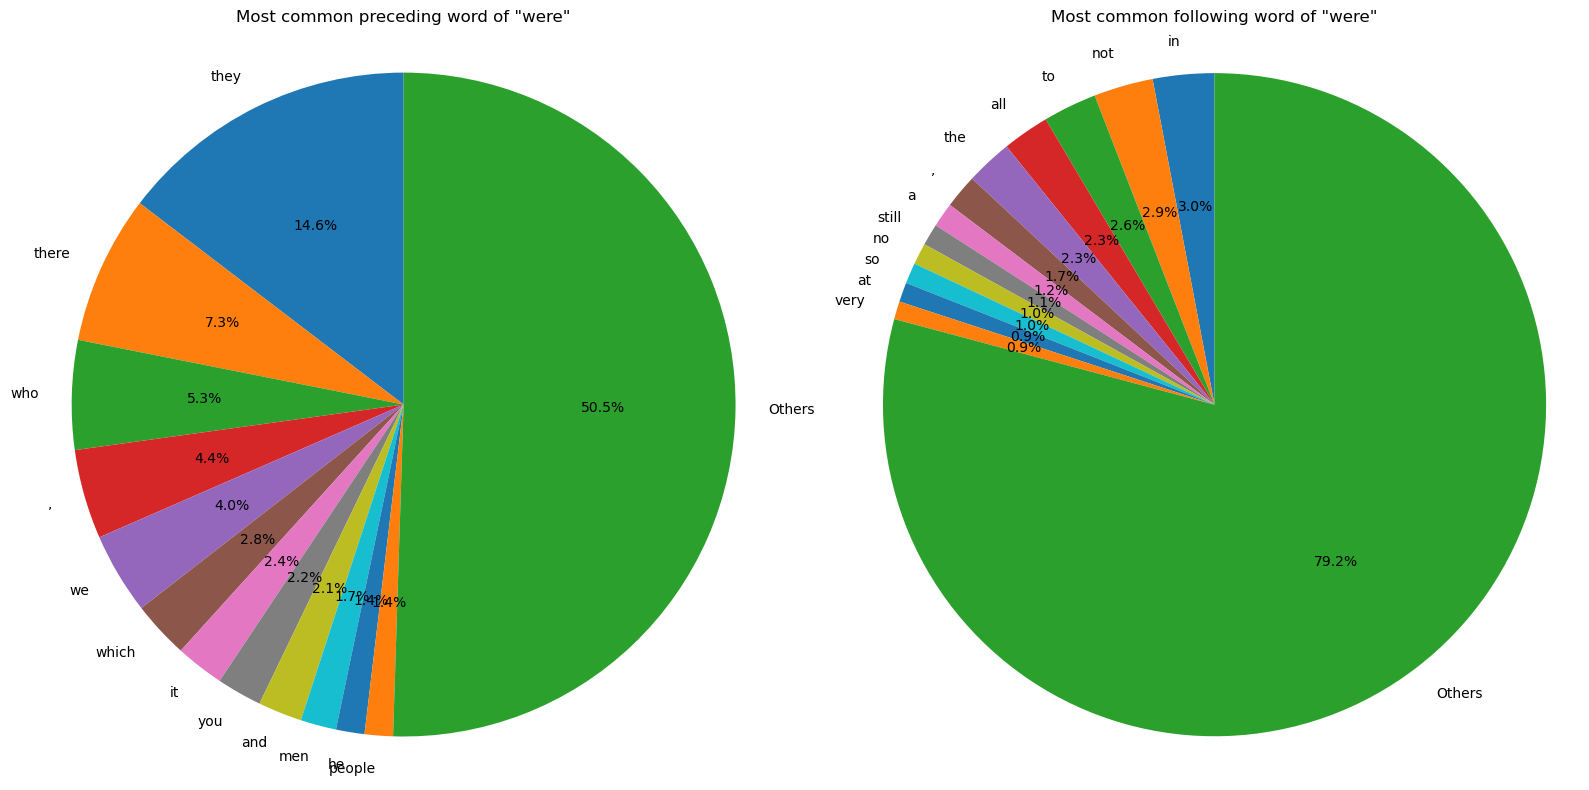

Studyng the word been most common preceding and following words


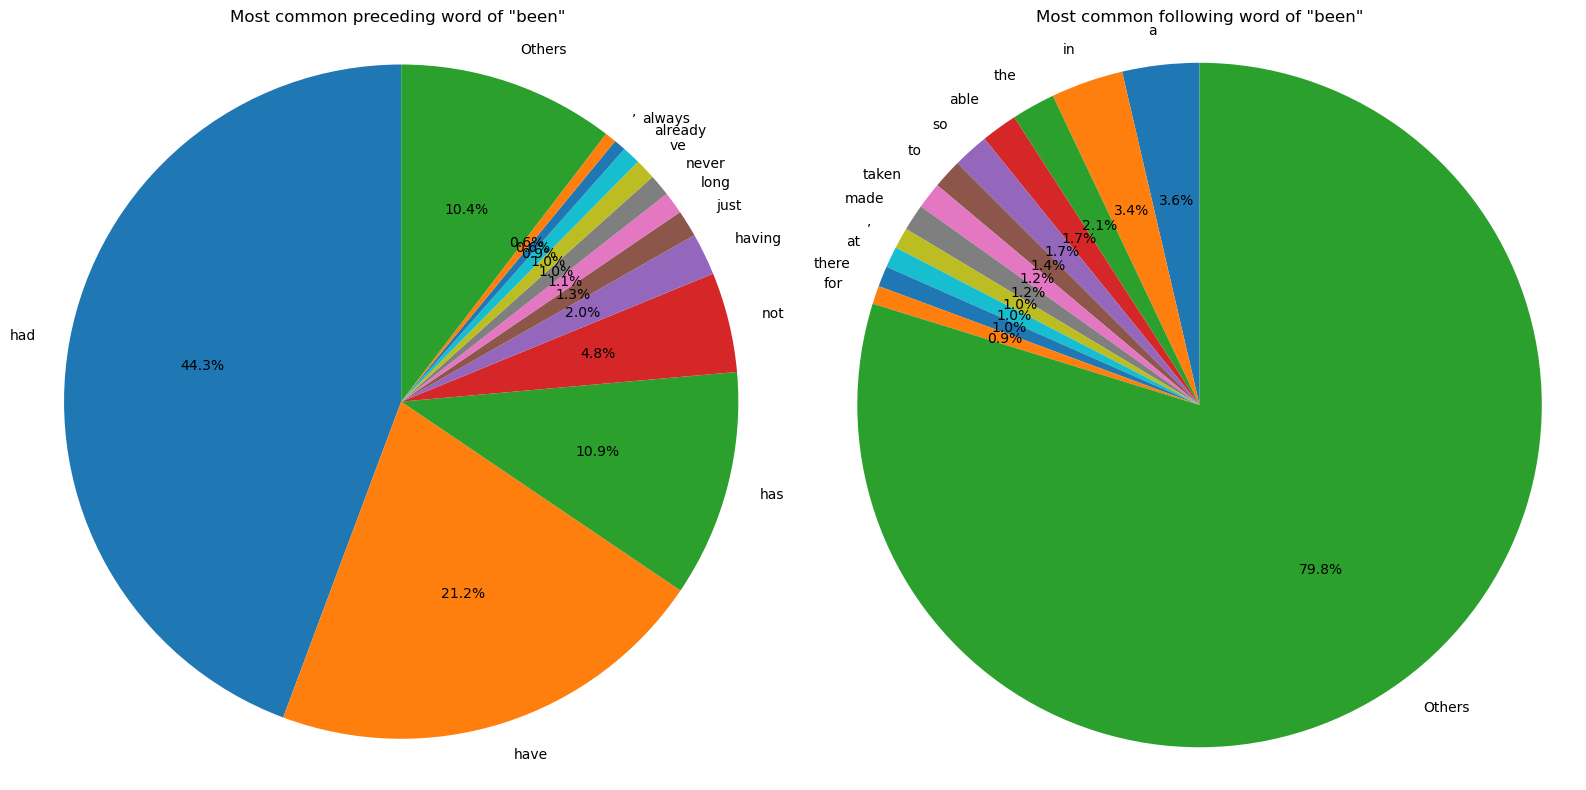

Studyng the word being most common preceding and following words


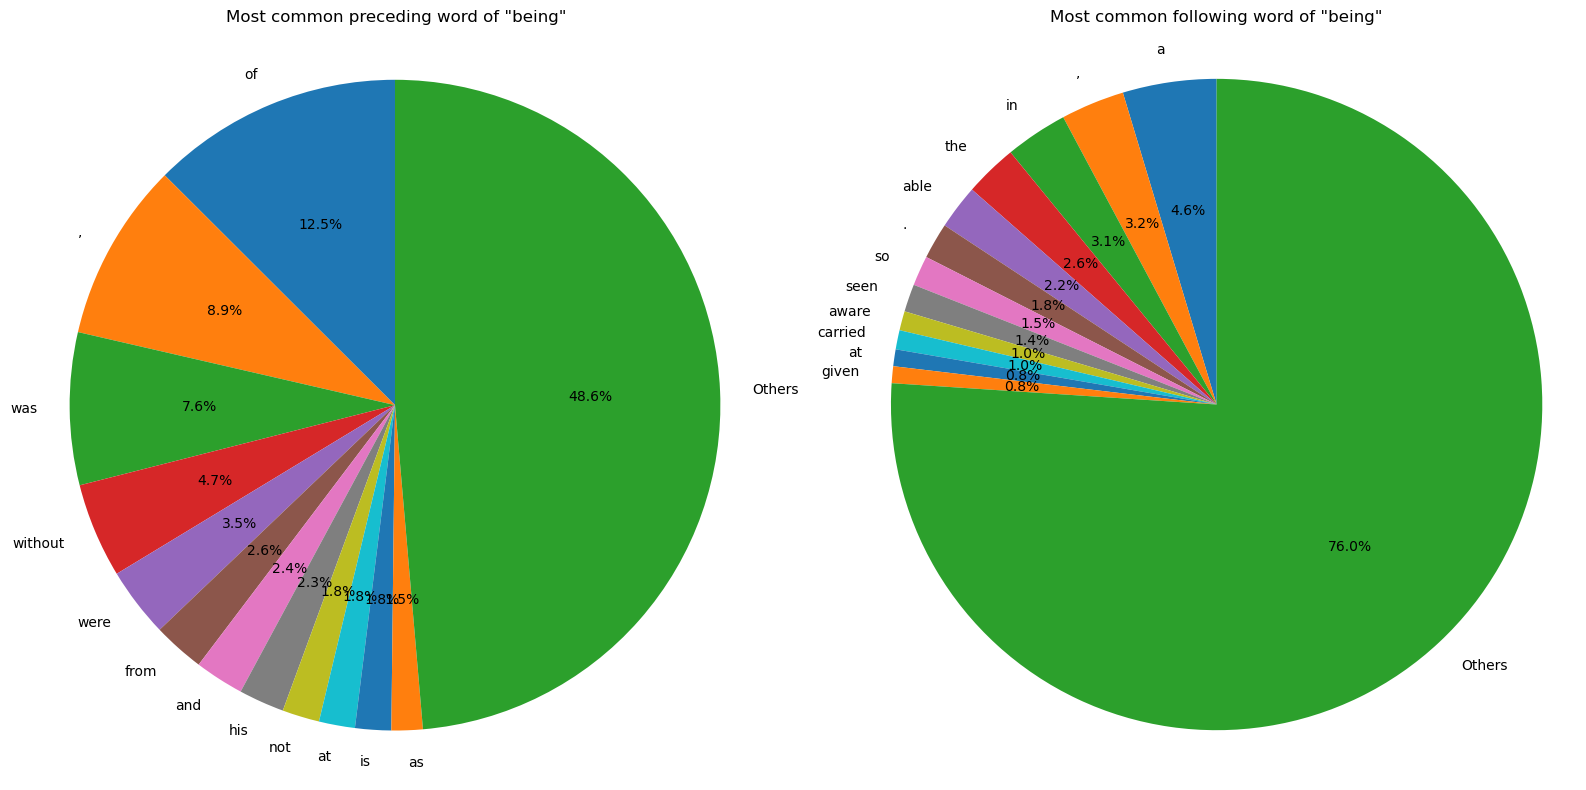

Studyng the word have most common preceding and following words


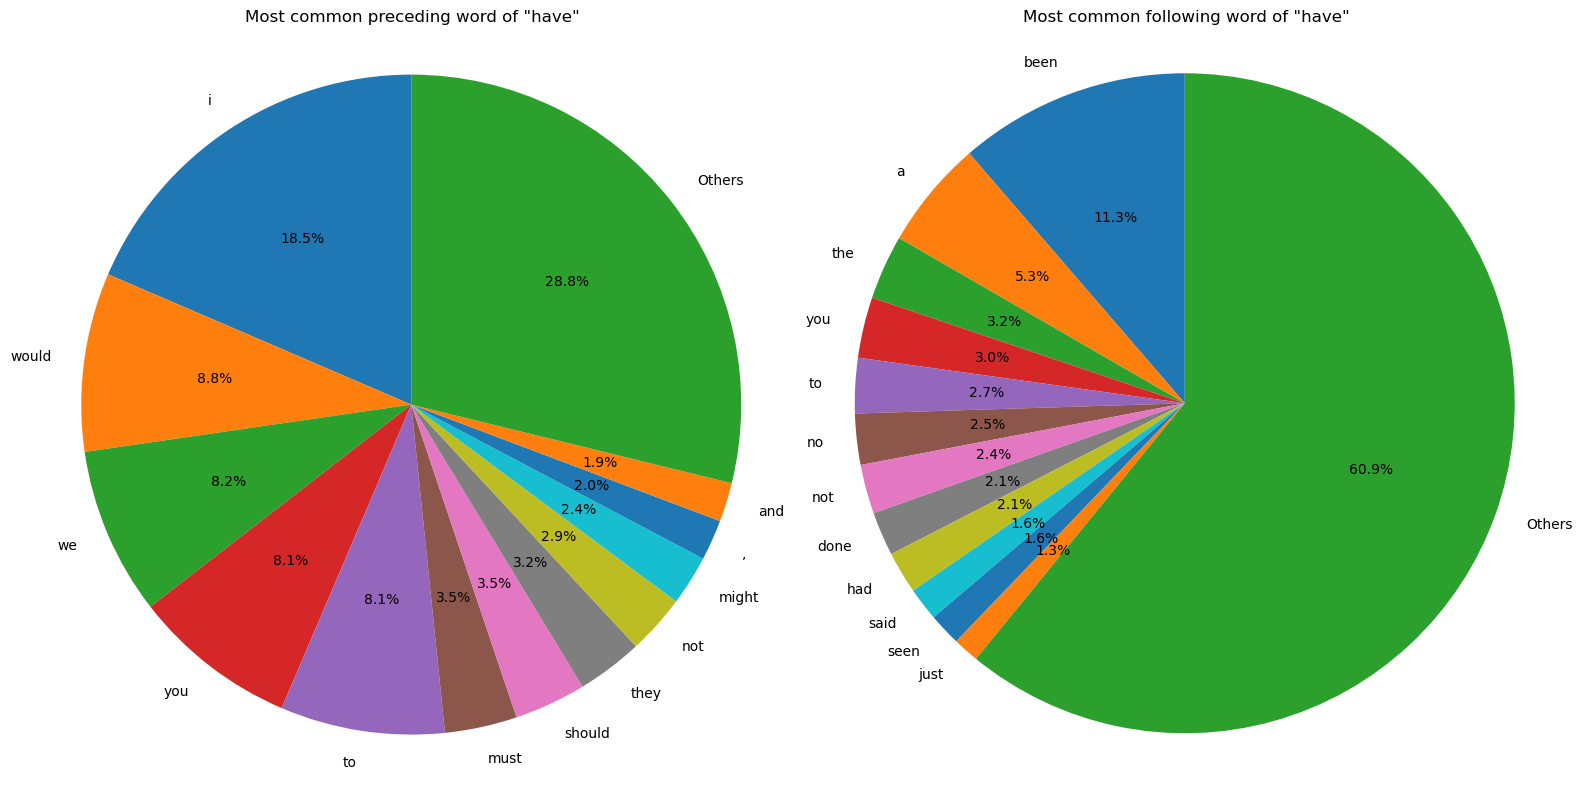

Studyng the word has most common preceding and following words


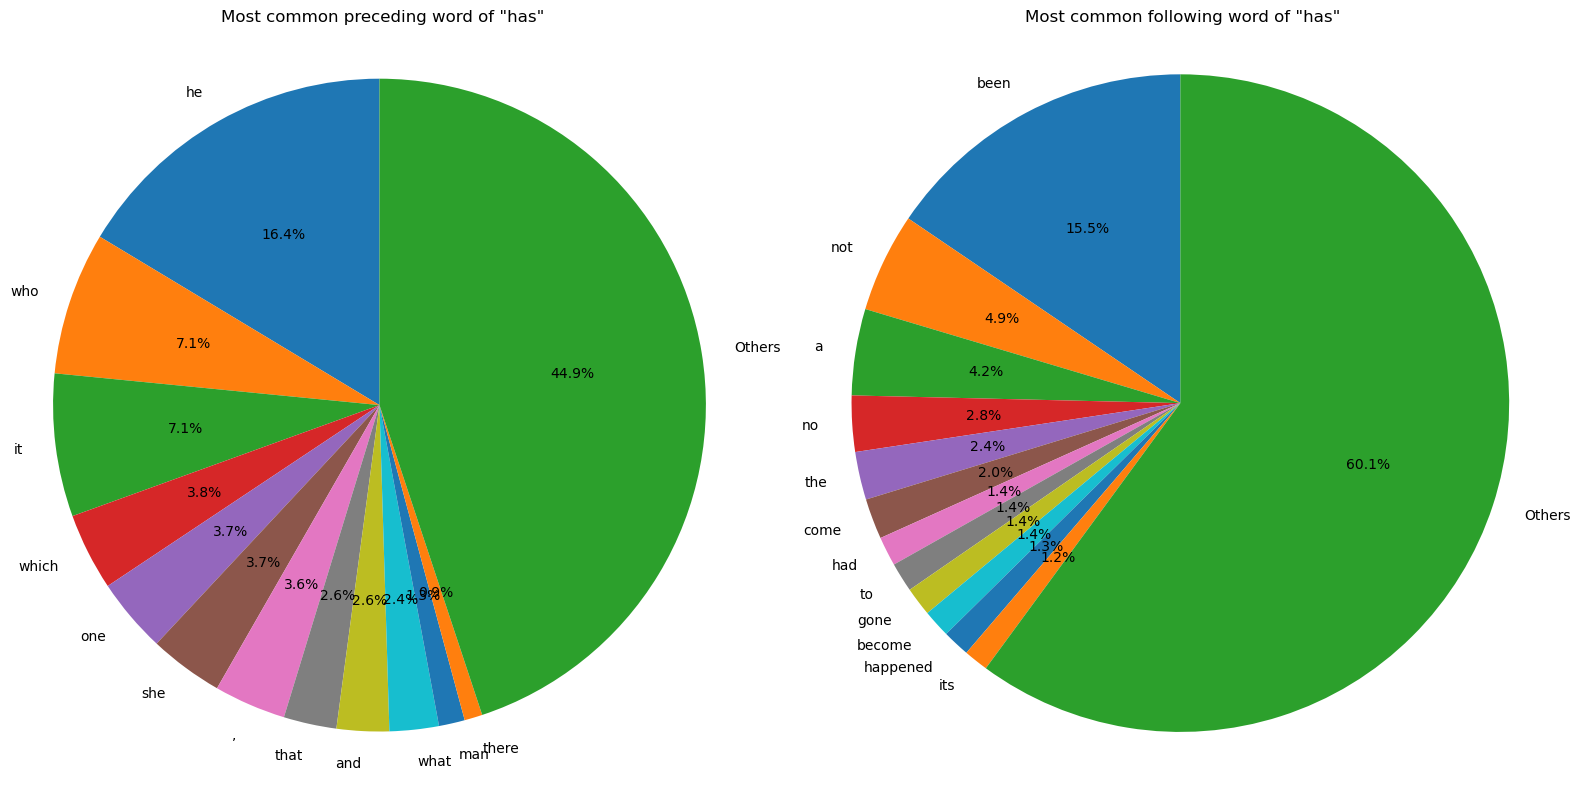

Studyng the word had most common preceding and following words


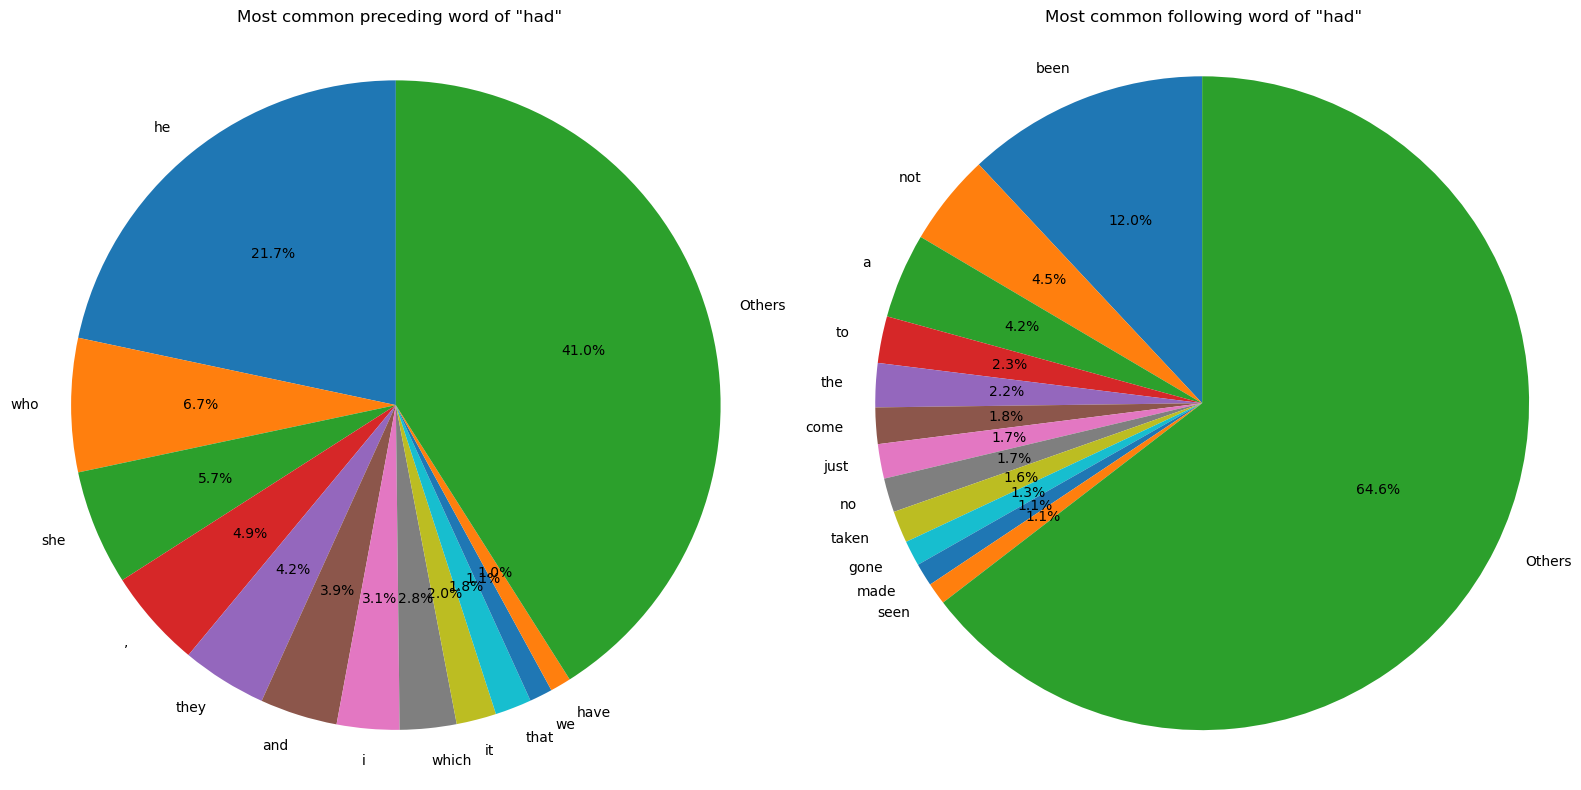

Studyng the word having most common preceding and following words


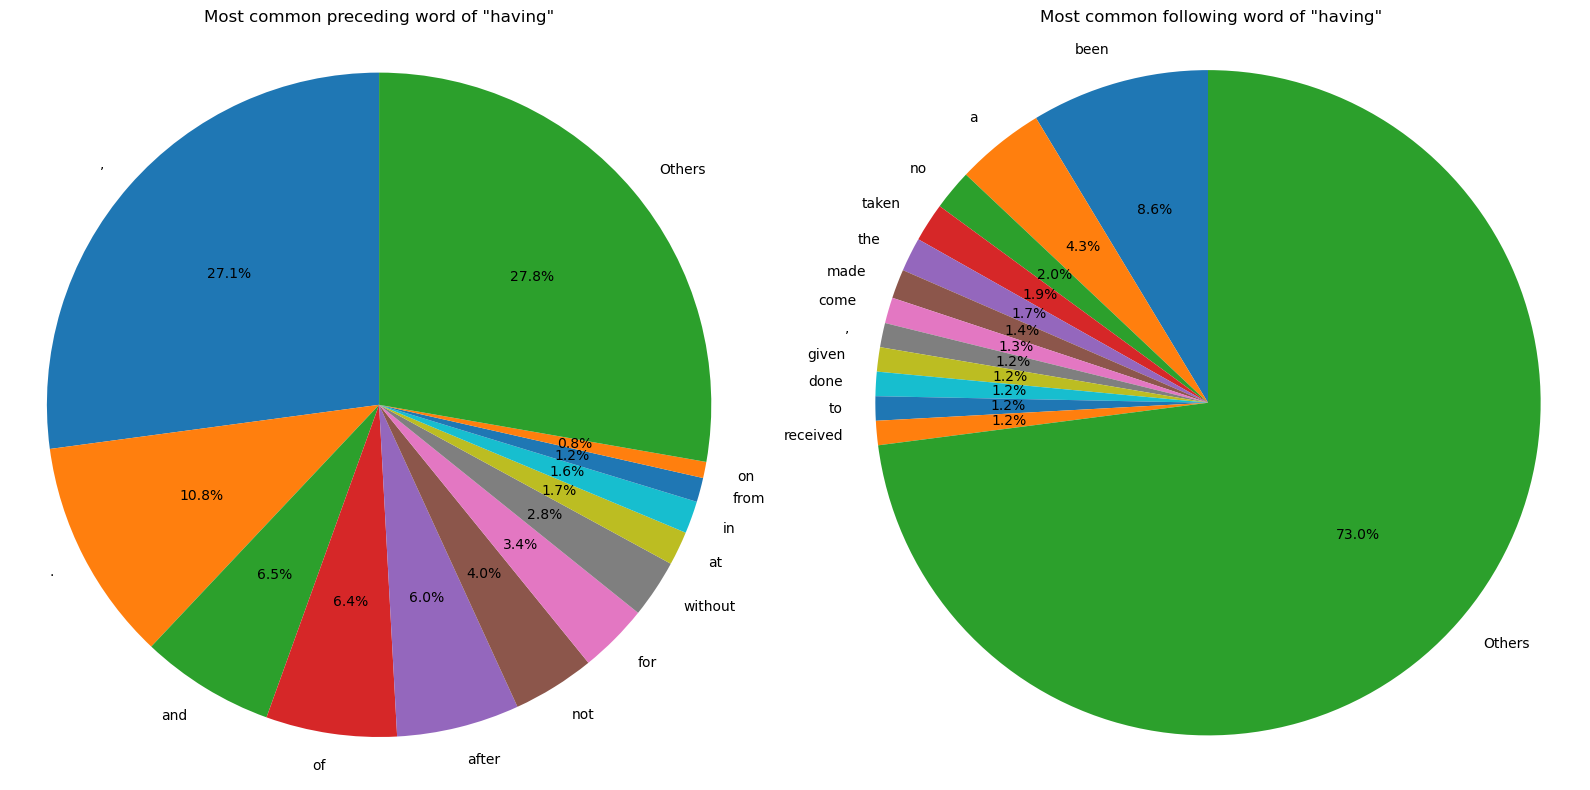

In [ ]:
def find_preceding_words(words, word_list):
    import re
    from collections import defaultdict, Counter
    
    # Diccionario para mantener contadores separados para cada palabra objetivo
    preceding_words = defaultdict(Counter)
    
    # Buscar cada palabra en la lista y registrar la palabra que la precede
    for i in range(1, len(words)):
        if words[i] in word_list:
            preceding_words[words[i]][words[i-1]] += 1
    
    # Convertir cada contador en una lista de las palabras más comunes y sus conteos
    most_common_preceding = {word: counter.most_common() for word, counter in preceding_words.items()}
    return most_common_preceding

preceding_words_TargetOutput = find_preceding_words(words_train, TARGET_OUTPUT)

def find_following_words(words, word_list):
    import re
    from collections import defaultdict, Counter
    
    # Diccionario para mantener contadores separados para cada palabra objetivo
    following_words = defaultdict(Counter)
    
    # Buscar cada palabra en la lista y registrar la palabra que la precede
    for i in range(0, len(words)-1):
        if words[i] in word_list:
            following_words[words[i]][words[i+1]] += 1
    
    # Convertir cada contador en una lista de las palabras más comunes y sus conteos
    most_common_following = {word: counter.most_common() for word, counter in following_words.items()}
    return most_common_following

preceding_words_TargetOutput = find_preceding_words(words_train, TARGET_OUTPUT)    
following_words_TargetOutput = find_following_words(words_train, TARGET_OUTPUT)


for target_word in TARGET_OUTPUT:
    print(f"Studyng the word {target_word} most common preceding and following words")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Create a figure with two subplots
    
    # Process data for preceding words
    data_preceding = preceding_words_TargetOutput[target_word]
    if len(data_preceding) > 12:
        top_data_preceding = data_preceding[:12]
        others_count_preceding = sum([item[1] for item in data_preceding[12:]])
        top_data_preceding.append(('Others', others_count_preceding))
    else:
        top_data_preceding = data_preceding

    labels_preceding = [item[0] for item in top_data_preceding]
    sizes_preceding = [item[1] for item in top_data_preceding]

    # Pie chart for preceding words
    ax[0].pie(sizes_preceding, labels=labels_preceding, autopct='%1.1f%%', startangle=90)
    ax[0].set_title(f'Most common preceding word of "{target_word}"')
    ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Process data for following words
    data_following = following_words_TargetOutput[target_word]
    if len(data_following) > 12:
        top_data_following = data_following[:12]
        others_count_following = sum([item[1] for item in data_following[12:]])
        top_data_following.append(('Others', others_count_following))
    else:
        top_data_following = data_following

    labels_following = [item[0] for item in top_data_following]
    sizes_following = [item[1] for item in top_data_following]

    # Pie chart for following words
    ax[1].pie(sizes_following, labels=labels_following, autopct='%1.1f%%', startangle=90)
    ax[1].set_title(f'Most common following word of "{target_word}"')
    ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()  # Automatically adjust subplots to fit the figure
    plt.show()


## 2.2.1 MLP and RNN prediction of be and have conjugation given the context around the target


Prepare the dataset with a set of words around the context

In [ ]:
target_to_idx = {target: i for i, target in enumerate(TARGET_OUTPUT)}

# Dict to get the index of each word
target_to_idx = {}

# Search for the word and get the index
for palabra in TARGET_OUTPUT:
    try:
        indice = vocab_conjugate_dict.index(palabra)
        target_to_idx[palabra] = indice
    except ValueError:
        print(f"The word:'{palabra}' was not found.")
        target_to_idx[palabra] = None

# Mostrar los resultados
print("Index in vocab of the target words:")
for i, (palabra, indice) in enumerate(target_to_idx.items()):
    if indice is not None:
        print(f"{i}: '{palabra}' has the index {indice}.")
    else:
        print(f"{i}: '{palabra}' is not in the list.")


batch_size = 256

before_context_size= 12; after_context_size=6
train_conjugate_data_12_6 = load_dataset(words_train, vocab_conjugate, "data_train_12_6.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
val_conjugate_data_12_6 = load_dataset(words_val, vocab_conjugate, "data_val_12_6.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
test_conjugate_data_12_6 = load_dataset(words_test, vocab_conjugate, "data_test_12_6.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)

train_conjugate_data_loader_12_6 = DataLoader(train_conjugate_data_12_6, batch_size=batch_size, shuffle=True)
val_conjugate_data_loader_12_6 = DataLoader(val_conjugate_data_12_6, batch_size=batch_size, shuffle=True)
test_conjugate_data_loader_12_6 = DataLoader(test_conjugate_data_12_6, batch_size=batch_size, shuffle=True)


# Creating Tensors for 5 words before and 5 after the target
before_context_size= 5; after_context_size=5
train_conjugate_data_5_5 = load_dataset(words_train, vocab_conjugate, "data_train_5_5.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
val_conjugate_data_5_5 = load_dataset(words_val, vocab_conjugate, "data_val_5_5.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
test_conjugate_data_5_5 = load_dataset(words_test, vocab_conjugate, "data_test_5_5.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)

train_conjugate_data_loader_5_5 = DataLoader(train_conjugate_data_5_5, batch_size=batch_size, shuffle=True)
val_conjugate_data_loader_5_5 = DataLoader(val_conjugate_data_5_5, batch_size=batch_size, shuffle=True)
test_conjugate_data_loader_5_5 = DataLoader(test_conjugate_data_5_5, batch_size=batch_size, shuffle=True)



Index in vocab of the target words:
0: 'be' has the index 0.
1: 'am' has the index 1.
2: 'are' has the index 2.
3: 'is' has the index 3.
4: 'was' has the index 4.
5: 'were' has the index 5.
6: 'been' has the index 6.
7: 'being' has the index 7.
8: 'have' has the index 8.
9: 'has' has the index 9.
10: 'had' has the index 10.
11: 'having' has the index 11.


Check the train data

In [ ]:
def showDataSet(train_data, vocab, index, before_context, after_context):
    start, end = index
    if start > end or start <0 or end>len(train_data): 
        print("Wrong indexes numbers")
        return

    for i in range(*index):
        input_tensor, target_tensor = train_data[i]
        input_tensor = input_tensor.tolist()
        target_tensor = target_tensor.item()

        # Inicializar la frase
        phrase = ""

        # Añadir las primeras 5 palabras del input_tensor a la frase
        for value in input_tensor[:before_context]:
            phrase += vocab[value] + " "

        # Añadir la palabra del target_tensor a la frase
        phrase += " *"+ vocab[target_tensor] + "* "

        # Añadir los últimos 2 valores del input_tensor a la frase
        for value in input_tensor[-after_context:]:
            phrase += vocab[value] + " "

        # Imprimir la frase completa
        print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", vocab[target_tensor], "}""\n   -> {", phrase.strip(),  "}")


index = (200, 203)
print("************** Tensors-> 12 Words before, 6 after examples: **************")
showDataSet(train_conjugate_data_12_6, vocab_conjugate_dict, index, 12, 6)

print("\n************** Tensors-> 5 Words before, 5 after examples: **************")
showDataSet(train_conjugate_data_5_5, vocab_conjugate_dict, index, 5, 5)

""" for i in range(*index):
    input_tensor, target_tensor = train_conjugate_data_12_6[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = ""

    # Añadir las primeras 5 palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += vocab_conjugate_dict[value] + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += " *"+ vocab_conjugate_dict[target_tensor] + "* "

    # Añadir los últimos 2 valores del input_tensor a la frase
    for value in input_tensor[-after_context_size:]:
        phrase += vocab_conjugate_dict[value] + " "

    # Imprimir la frase completa
    print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", vocab_conjugate_dict[target_tensor], "}""\n   -> {", phrase.strip(),  "}")

print("\n************** Tensors-> 5 Words before, 5 after examples: **************")
for i in range(*index):
    input_tensor, target_tensor = train_conjugate_data_5_5[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = " "

    # Añadir las primeras 5 palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += vocab_conjugate_dict[value] + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += "*"+ vocab_conjugate_dict[target_tensor] + "* "

    # Añadir los últimos 2 valores del input_tensor a la frase
    for value in input_tensor[-after_context_size:]:
        phrase += vocab_conjugate_dict[value] + " "

    # Imprimir la frase completa
    print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", vocab_conjugate_dict[target_tensor], "}""\n   -> {", phrase.strip(),  "}")
 """

************** Tensors-> 12 Words before, 6 after examples: **************
 Input:  [13, 37, 3692, 804, 14, 917, 7489, 17, 3691, 2164, 15, 16, 1893, 85, 13, 21, 4, 23435]  Target:  7 -> { being }
   -> { , which characteristic formed the real eloquence of jesus christ . and  *being* convinced himself , he was persuasive }
 Input:  [917, 7489, 17, 3691, 2164, 15, 16, 7, 1893, 85, 13, 21, 23435, 15, 312, 30175, 7244, 18]  Target:  4 -> { was }
   -> { real eloquence of jesus christ . and being convinced himself , he  *was* persuasive . chapter iv—works corresponding to }
 Input:  [13, 21, 4, 23435, 15, 312, 30175, 7244, 18, 259, 23, 680, 1781, 16, 12960, 15, 21, 202]  Target:  4 -> { was }
   -> { , he was persuasive . chapter iv—works corresponding to words his conversation  *was* gay and affable . he put }

************** Tensors-> 5 Words before, 5 after examples: **************
 Input:  [17, 3691, 2164, 15, 16, 1893, 85, 13, 21, 4]  Target:  7 -> { being }
   -> { of jesus christ . a

' for i in range(*index):\n    input_tensor, target_tensor = train_conjugate_data_12_6[i]\n    input_tensor = input_tensor.tolist()\n    target_tensor = target_tensor.item()\n\n    # Inicializar la frase\n    phrase = ""\n\n    # Añadir las primeras 5 palabras del input_tensor a la frase\n    for value in input_tensor[:before_context_size]:\n        phrase += vocab_conjugate_dict[value] + " "\n\n    # Añadir la palabra del target_tensor a la frase\n    phrase += " *"+ vocab_conjugate_dict[target_tensor] + "* "\n\n    # Añadir los últimos 2 valores del input_tensor a la frase\n    for value in input_tensor[-after_context_size:]:\n        phrase += vocab_conjugate_dict[value] + " "\n\n    # Imprimir la frase completa\n    print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", vocab_conjugate_dict[target_tensor], "}""\n   -> {", phrase.strip(),  "}")\n\nprint("\n************** Tensors-> 5 Words before, 5 after examples: **************")\nfor i in range(*index):\n    input_tens

### Create the models

#### RNN model

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        last_hidden = output[:, -1, :]
        out = self.fc(last_hidden)
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            _, predicted_index = torch.max(output, 1)
        return predicted_index

#### MLP model

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_weights, output_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.load_state_dict({"weight": embedding_weights})
        self.embeddings.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=output_dim),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        output = self.classifier(embeds)

        # Only ouput class label, not features
        output = output[:, 0, :]

        return output

## 2.2.2. Train models and evaluate performance


#### Train the RNN models

trained with 16 words context before and 4 words context after

In [ ]:
models_5_5 = [] # Models trained with 5 words before and 5 after
models_5_5_titles = [] # Titles

models_12_6 = [] # Models trained with 12 words before 6 after
models_12_6_titles = [] # Titles


In [ ]:
def train_all_rnn_models(learning_rates, hidden_dimensions, train_loaders, vocab, output_dim, n_epochs):

    rnn_model_counter=0
    loss_fn = nn.CrossEntropyLoss()

    for train_loader, train_loader_title in train_loaders:  # For every change in the amount of words we pick before/after the target 
        print("\n\nTraning the Dataloader: ", train_loader_title)
        for hidden_dimension in hidden_dimensions:     # For every model we create
            print("  \nTraning the model-dimension: ", hidden_dimension)
            for learning_rate in learning_rates:      # For every learning rate
            
                model =  RNNModel(len(vocab), embedding_dim, hidden_dimension, output_dim)
                
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                rnn_model_counter +=1
                print("    "+str(rnn_model_counter)+". Traning the lr: ", learning_rate)
                modelTitle= "RNN_"+str(rnn_model_counter) +"_(dim="+str(hidden_dimension)+","+ train_loader_title +")_lr=" +str(learning_rate) 

                file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
                
                if os.path.isfile(file_path): # If it has not been trained before
                    model = torch.load(file_path)
                else:
                    train(n_epochs, optimizer, model, loss_fn, train_loader)
                    torch.save(model, file_path)

                if train_loader_title == "Before=5,After=5":
                    if modelTitle not in titles: # Dont add again if it is already there
                        models_5_5.append(model)
                        models_5_5_titles.append(modelTitle)
                        
                elif train_loader_title == "Before=12,After=6":
                    if modelTitle not in titles: # Dont add again if it is already there
                        models_12_6.append(model)
                        models_12_6_titles.append(modelTitle)
                


In [ ]:
learning_rates=[0.001]
hidden_dim=[100, 300, 700, 1500]
n_epochs = 300 # 485 is the maximum
train_loaders=[(train_conjugate_data_loader_5_5,"Before=5,After=5") , (train_conjugate_data_loader_12_6, "Before=12,After=6")]

train_all_rnn_models(learning_rates, hidden_dim, train_loaders, vocab_conjugate, len(TARGET_OUTPUT), n_epochs)





Traning the Dataloader:  Before=5,After=5
  
Traning the model-dimension:  100
    1. Traning the lr:  0.001
On device cpu.
21:20:19.749061  |  Epoch 1  |  Training loss 1.84050
21:21:08.081015  |  Epoch 5  |  Training loss 1.00449
21:22:11.208163  |  Epoch 10  |  Training loss 0.78088
21:23:14.075937  |  Epoch 15  |  Training loss 0.63692
21:24:17.221594  |  Epoch 20  |  Training loss 0.52248
21:25:20.154943  |  Epoch 25  |  Training loss 0.42691
21:26:24.090883  |  Epoch 30  |  Training loss 0.34406
21:27:27.190921  |  Epoch 35  |  Training loss 0.27483
21:28:30.118586  |  Epoch 40  |  Training loss 0.21594
21:29:32.829824  |  Epoch 45  |  Training loss 0.16549
21:30:35.682561  |  Epoch 50  |  Training loss 0.12468
21:31:39.069053  |  Epoch 55  |  Training loss 0.09172
21:32:41.872300  |  Epoch 60  |  Training loss 0.07430
21:33:44.706190  |  Epoch 65  |  Training loss 0.04924
21:34:47.615242  |  Epoch 70  |  Training loss 0.03720
21:35:51.429669  |  Epoch 75  |  Training loss 0.02

KeyboardInterrupt: 

Demostration of the predictions

In [ ]:
# train_loaders=[(train_conjugate_data_loader_5_5,"Before=5,After=5") , (train_conjugate_data_loader_12_6, "Before=12,After=6")]
showPredictSamples(models_5_5, models_5_5_titles, vocab_conjugate_dict, train_conjugate_data_5_5, since=110, to=113)
showPredictSamples(models_12_6, models_12_6_titles, vocab_conjugate_dict, train_conjugate_data_12_6, since=110, to=113)


Here we can see better some examples of how the neural network is working for each model in each type of data

Selection of the best model

We now have to change a little bit how we meausre the performace as we have different approaches. For example we have an approach that will read 12 words before the target and 6 after and another approach that will instead read 5 before and 5 after. Each have different train/val/test DataLoaders, so we can not mix them.

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of model with given data loader
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / len(loader.dataset)

def accuracy_expanded(model, loader, target_words):
    """
    Gives detailed information for each word accuracy
    """
    model.eval()
    evaluation = []
    for _ in range(len(target_words)):
        evaluation.append([0, 0]) # Save the correct / total predictions
        
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            for i in range(len(contexts)):
                context = contexts[i].unsqueeze(0)  # Agrega una dimensión de batch
                answer = labels[i].item()   
                with torch.no_grad():
                    output = model(context)
                    _, predicted_index = torch.max(output, 1)
                    predicted_index = predicted_index.item()  # Convierte el tensor a un entero Python
                evaluation[answer][0] += (predicted_index == answer) # Correct prediction, sum 1
                evaluation[answer][1] += 1 

    return evaluation

def model_selection_acc(models, titles, train_loader, val_loader):
    """
    Choose the best model from the list of models based on validation accuracy and returns the best accuracy 
    """
    best_model = None
    best_acc = 0
    for model, title in zip(models, titles):
        acc = accuracy(model, val_loader)
        train_acc = accuracy(model, train_loader)
        print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
        if acc > best_acc:
            best_model = model
            best_acc = acc
    return best_model, best_acc


def model_selection_multipleLoaders(data):
    best_model = None
    best_acc = 0
    best_loader = None

    for conjugation in data:
        title, models, titles, train_loader, val_loader, test_loader = conjugation
        print(f"Trying configuration: {title}")
        model, acc = model_selection_acc(models, titles, train_loader, val_loader)
        if acc > best_acc:
            best_model = model
            best_acc = acc
            best_loader = test_loader
    return best_model, best_loader




In [ ]:

all_models_data=[
                    ['5 words before, 5 after', models_5_5, models_5_5_titles, train_conjugate_data_loader_5_5, val_conjugate_data_loader_5_5, test_conjugate_data_loader_5_5],
                    ['12 words before, 6 after', models_12_6, models_12_6_titles, train_conjugate_data_loader_12_6, val_conjugate_data_loader_12_6, test_conjugate_data_loader_12_6]
          ]

best_model, test_loader_conjugate = model_selection_multipleLoaders(all_models_data)

print(f"\nThe best model is: {best_model}")

best_model_acc = accuracy(best_model, test_loader_conjugate)
print(f"Best conjugating model | Test accuracy {best_model_acc:.2%}")


Now based on the best model show the accuracy of each word

In [ ]:
expanded_accuracy = accuracy_expanded(best_model, test_loader_conjugate, TARGET_OUTPUT)
print(expanded_accuracy)

labels = []
for i,word in enumerate(TARGET_OUTPUT):
    correct, total = expanded_accuracy[i]
    if total != 0:
        labels.append(f"{word}\n({correct}/{total})")


percentages = [(correct / total) * 100 if total > 0 else 0 for correct, total in expanded_accuracy]

# Nombres de los elementos (opcional, puede ser simplemente índices)

plt.figure(figsize=(10, 6))  # Configura el tamaño de la figura
plt.bar(labels, percentages, color='blue')  # Crea un gráfico de barras
plt.xlabel('Items')
plt.ylabel('Percentage of Correct Predictions (%)')
plt.title('Accuracy Rate per Word')
plt.ylim(0, 100)  # Establece el límite del eje Y de 0 a 100%
plt.xticks(rotation=45)  # Rota las etiquetas del eje X para mejor visibilidad
plt.show()

Here we can apreciate the percentage of correct predictions for each name and the total amount of samples that were taken for each of them

_______________________________
# 2.3 Text generation:
## 2.3.1. Next Word


## 2.3.2. Train models and evaluate performance


## 2.3.3. Beam Search


## 2.3.3. Sentence creation